# NYU-CUSP Principles of Urban Informatics 2017 final

## READ THE [README](README.md) AND THE [RULES](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_RULES.ipynb) FIRST! **


There are [hints](https://docs.google.com/document/d/1lXM07wQsbxXKfCbWYP6RJlDqFOl0E1LWWzLVJ0bEmAM/edit?usp=sharing) and further details on the data in [PUI2017final_DATA](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_DATA.ipynb) 

**Motivation:**

The study of NYC crime is of broad interest in the Urban Science scene, and NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods (opportunity), and to how easy it is to commit a crime (the neighborhood safety, or perceived safety). [It has been suggested](https://journalistsresource.org/studies/government/criminal-justice/unemployment-property-crime-burglary) that unemployment correlates strongly with burglary for example, due to both opportunity and motivation. In addition there are [several pieces of research](https://www.citylab.com/solutions/2016/04/vacant-lots-green-space-crime-research-statistics/476040/) that indicate that access to green spaces affects crime.

In this final you should explore and model NYC crime:

- The first part of the exam is an exploratory analysis of the crime time series for the seven major felonies 2000-2016 (temporal domain).

- The second part of the exam attempts to relate socioeconomic features to individual crime rates by area (spatial domain).

- Lastly, if you wish, in the extra credit, you can aggregate the socioeconomic features that I indicated at the precinct level: percentage of unemployment and median income, that natively come at the census tract level from the census bureau API, and green area, for which you can use the NYC parks shapefile.


There are [hints](https://docs.google.com/document/d/1lXM07wQsbxXKfCbWYP6RJlDqFOl0E1LWWzLVJ0bEmAM/edit?usp=sharing), and partially processed datasets. Look for them. As in the midterm you can access the partially processed datasets (only one in this case) and go back to the processing task at a later time. If you then provide your own processing of the data you will be given points accordingly.


In [1]:
#Importing the libraries
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from urllib import urlencode
from urllib2 import urlopen, HTTPError
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

import ast
import io
import os
import zipfile
import requests

import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn import preprocessing
from sklearn import cross_validation 
from sklearn import cluster
from sklearn.metrics import silhouette_score
import choroplethNYC as cp #importing federica's python file
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
import time
import random
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import sklearn.datasets as datasets

np.random.seed(222)
#import matplotlib.cm as cm
%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Time domain exploratory analysis

## 1.1 obtain historical data for 2000-2016 for all NYC police precincts
you can obtain the data from NYC.gov it should be an excel file called seven-major-felony-offenses-by-precinct-2000-2016.xls

In [2]:
#loading the file
url = 'http://www.nyc.gov/html/nypd/downloads/excel/analysis_and_planning/seven-major-felony-offenses-by-precinct-2000-2016.xls'
cache_name = os.path.basename(url)
xls_file = os.path.join(os.getenv('PUIDATA', './'), cache_name)
if not os.path.isfile(xls_file):
    print('Loading from url.')
    open(xls_file, 'w').write(requests.get(url).content)

In [3]:
#reading the excel file, removing the unwanted rows
crime = pd.read_excel(xls_file, skiprows = 2, skip_footer = 20)

In [4]:
#forward fill
crime = crime.fillna(method="ffill") 

In [5]:
#strip off the white spaces  from the crime names
crime["CRIME"] = crime.CRIME.str.strip()

In [6]:
#converting all column names to string
crime.columns = crime.columns.astype(str) 

In [7]:
#printing all the column names to check if they are in string format now
crime.columns

Index([u'PCT', u'CRIME', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005',
       u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013',
       u'2014', u'2015', u'2016'],
      dtype='object')

In [8]:
#check the layout of the crime dataframe (head)
crime.head(8)

PCT                              CRIME    2000    2001    2002    2003  \
0  1.0    MURDER & NON NEGL. MANSLAUGHTER     3.0     1.0     2.0     2.0   
1  1.0                               RAPE    12.0     5.0    10.0    11.0   
2  1.0                            ROBBERY   252.0   188.0   210.0   164.0   
3  1.0                     FELONY ASSAULT   139.0   164.0   147.0   134.0   
4  1.0                           BURGLARY   475.0   437.0   297.0   403.0   
5  1.0                      GRAND LARCENY  2358.0  2117.0  1896.0  1803.0   
6  1.0     GRAND LARCENY OF MOTOR VEHICLE   199.0   157.0   153.0   132.0   
7  1.0  TOTAL SEVEN MAJOR FELONY OFFENSES  3438.0  3069.0  2715.0  2649.0   

     2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0     2.0     0.0     1.0     0.0     1.0     2.0     2.0     0.0     1.0   
1    11.0     5.0     4.0     7.0    12.0     4.0     6.0    13.0    10.0   
2   154.0   172.0   119.0   128.0   108.0   106.0    96.0   102.0    81.0   
3   129.0   121.0    94.0    90.0    83.0    83.0    68.0    94.0   110.0   
4   246.0   293.0   255.0   231.0   189.0   207.0   170.0   155.0   188.0   
5  1708.0  1624.0  1462.0  1395.0  1258.0  1122.0  1065.0   979.0   985.0   
6   133.0    90.0    78.0    63.0    57.0    54.0    38.0    59.0    41.0   
7  2383.0  2305.0  2013.0  1914.0  1708.0  1578.0  1445.0  1402.0  1416.0   

   2013  2014  2015  2016  
0     0     0     1     0  
1    12     8     7     9  
2    68    50    79    60  
3    87    76    86    78  
4   171   145   138   117  
5  1051   896  1114  1081  
6    27    33    21    50  
7  1416  1208  1446  1395

In [9]:
#checking the layout of the crime dataframe (tail)
crime.tail(3)

PCT                              CRIME   2000   2001   2002   2003  \
613  123.0                      GRAND LARCENY  101.0   90.0  116.0  137.0   
614  123.0     GRAND LARCENY OF MOTOR VEHICLE  266.0  193.0  143.0  131.0   
615  123.0  TOTAL SEVEN MAJOR FELONY OFFENSES  636.0  514.0  495.0  467.0   

      2004   2005   2006   2007   2008   2009   2010   2011   2012  2013  \
613  166.0  233.0  175.0  181.0  191.0  171.0  147.0  175.0  183.0   171   
614   95.0   96.0  114.0   87.0   81.0   51.0   39.0   48.0   31.0    40   
615  464.0  570.0  475.0  496.0  515.0  414.0  371.0  413.0  396.0   378   

     2014  2015  2016  
613   194   163   145  
614    30    20    23  
615   378   348   302

In [10]:
#seeing the statistics summary of the dataframe
crime.describe()

PCT         2000         2001         2002         2003  \
count  616.000000   616.000000   616.000000   616.000000   616.000000   
mean    63.324675   630.000000   555.519481   528.185065   500.068182   
std     35.912248   900.431273   803.464097   751.273625   708.304736   
min      1.000000     0.000000     0.000000     0.000000     0.000000   
25%     32.000000    61.250000    62.000000    63.000000    50.750000   
50%     66.000000   347.000000   301.500000   293.000000   267.000000   
75%    100.000000   674.500000   590.250000   570.250000   540.250000   
max    123.000000  6857.000000  6088.000000  5265.000000  5105.000000   

              2004         2005         2006         2007         2008  \
count   616.000000   616.000000   616.000000   616.000000   616.000000   
mean    484.522727   463.386364   440.162338   415.042208   404.948052   
std     686.364799   648.174813   611.765155   580.523334   565.118260   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      50.000000    48.000000    39.750000    37.000000    35.750000   
50%     266.500000   259.500000   241.000000   217.500000   211.000000   
75%     502.250000   481.250000   466.250000   446.500000   441.500000   
max    4730.000000  4423.000000  4173.000000  3971.000000  3708.000000   

              2009         2010         2011         2012         2013  \
count   616.000000   616.000000   616.000000   616.000000   616.000000   
mean    366.071429   361.373377   367.496753   386.298701   361.477273   
std     513.226115   503.908341   512.525765   542.480900   517.823164   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      32.000000    33.000000    29.000000    30.000000    27.750000   
50%     198.000000   187.000000   188.500000   188.500000   171.000000   
75%     404.250000   404.250000   407.250000   449.250000   433.000000   
max    3330.000000  3103.000000  3393.000000  3780.000000  3902.000000   

              2014         2015         2016  
count   616.000000   616.000000   616.000000  
mean    345.159091   341.149351   328.594156  
std     495.810111   489.549460   479.298564  
min       0.000000     0.000000     0.000000  
25%      29.000000    30.000000    28.750000  
50%     165.000000   159.000000   140.000000  
75%     410.500000   388.500000   384.750000  
max    3751.000000  3506.000000  3287.000000

In [11]:
#checking the shape of the dataframe
crime.shape

(616, 19)

## 1.2 remove outliers (likely wrongly input data)


In the data I downloaded (last download yesterday) there was a wrong set of rows for one precinct. You should be able to see it when you plot the time series. The values are obviously wrong (extremely large for all crimes). 



In [12]:
#Federica - the tail of your DF should look like this: 
#remove rows that are not for a precinct (all precincts are identified by numbers)

#Me - already done in part 1.1
crime.tail(3)

PCT                              CRIME   2000   2001   2002   2003  \
613  123.0                      GRAND LARCENY  101.0   90.0  116.0  137.0   
614  123.0     GRAND LARCENY OF MOTOR VEHICLE  266.0  193.0  143.0  131.0   
615  123.0  TOTAL SEVEN MAJOR FELONY OFFENSES  636.0  514.0  495.0  467.0   

      2004   2005   2006   2007   2008   2009   2010   2011   2012  2013  \
613  166.0  233.0  175.0  181.0  191.0  171.0  147.0  175.0  183.0   171   
614   95.0   96.0  114.0   87.0   81.0   51.0   39.0   48.0   31.0    40   
615  464.0  570.0  475.0  496.0  515.0  414.0  371.0  413.0  396.0   378   

     2014  2015  2016  
613   194   163   145  
614    30    20    23  
615   378   348   302

## 1.3  Plot the time series for each of the seven major felonies and for the total (aggregation of all felonies). 
There is a lot of data to plot. See the hints on how to get the time series to plot for the dataframe if you want to, or extract the data and plot with pylab. But be thoughtful about how you organize the display of information.
This will help you spot the wrong rows if you do it before the outlier rejection (that is how I realized there was an outlier). Make sure your plot shows the clean dataset though. 

In [13]:
#making sure the dataframe has appropriate numeric values for the respective columns
crime.dtypes

PCT      float64
CRIME     object
2000     float64
2001     float64
2002     float64
2003     float64
2004     float64
2005     float64
2006     float64
2007     float64
2008     float64
2009     float64
2010     float64
2011     float64
2012     float64
2013       int64
2014       int64
2015       int64
2016       int64
dtype: object

Maximum number of Total number of reproted crimes 186999.0
Minimum number of Total number of reproted crimes 101207.0


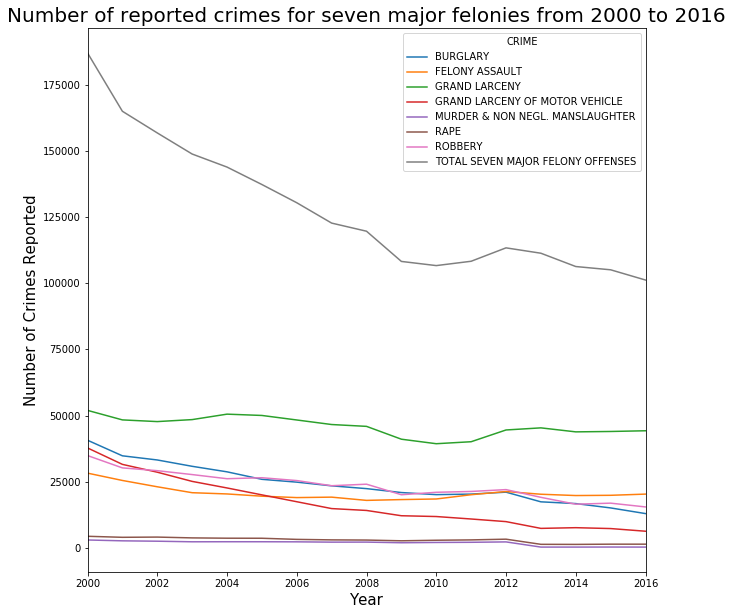

In [14]:
#grouping the crime dataframe by sum of the "CRIME" column
crime_group = crime.groupby(crime["CRIME"]).sum()

#transposing the crime_group and dropping PCT because I only want to plot the time series of number of crimes
crime_group_dropped = crime_group.T.drop('PCT', axis=0)

print("Maximum number of Total number of reproted crimes", max(crime_group_dropped["TOTAL SEVEN MAJOR FELONY OFFENSES"]))
print("Minimum number of Total number of reproted crimes", min(crime_group_dropped["TOTAL SEVEN MAJOR FELONY OFFENSES"]))

#plotting the graph for number of reported crimes for seven major felonies from 2000 to 2016
#to see overall trend of the crime data
ax = crime_group_dropped.plot(figsize=(10,10))
ax.set_title("Number of reported crimes for seven major felonies from 2000 to 2016", fontsize = 20)
ax.set_xlabel("Year", fontsize = 15)
ax.set_ylabel("Number of Crimes Reported", fontsize = 15)

## Figure 1: Time series plot (2000 to 2016) showing the number of crimes reported by crime type (7 major felonies) and the total.  

### As can be seen from the figure above, highest number of crimes is for Grand Larceny, whereas the least is for Rape and Murder & Non Negl. Manslaughter. One of the main reasons could be that, Grand Larceny is usually reported the most because people can claim their insurance on it and hence are reported easily, whereas Rape is considered a taboo and might not get reported due to societal pressure. Murder & Non Negl. Manslaughter may simply not occur a lot in NYC. Overall the timeseries plot shows that total number of reported crimes have decreased from 186999.0 in 2000 to 101207.0 in 2016, that is decreased by 46% approximately.


In [15]:
crime.shape

(616, 19)

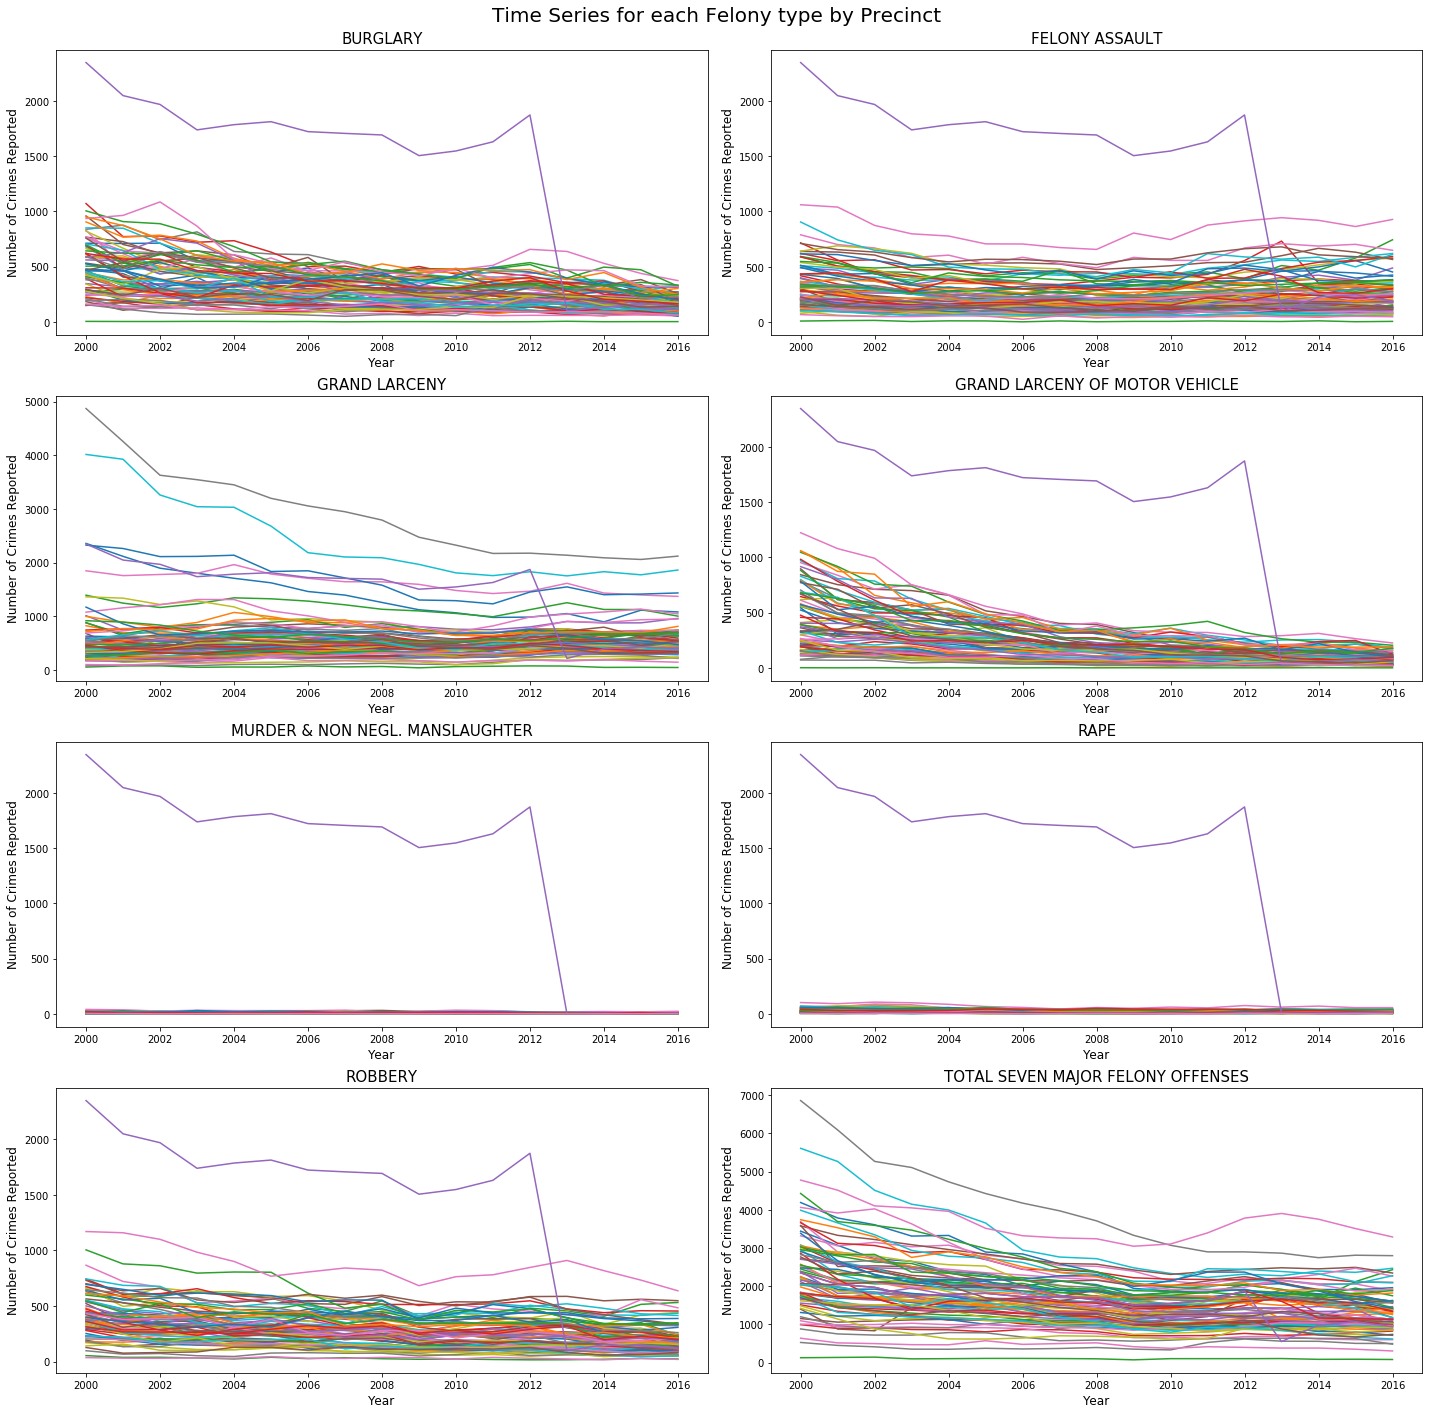

In [16]:
#Plotting out the time series for each felony type by precinct to check how the data looks like on a more granular level
fig = plt.figure(figsize = (20,20))
fig.suptitle("Time Series for each Felony type by Precinct", fontsize=20)

#for loop to show plot for each felony type
for i, (crime_name,group) in enumerate(crime.groupby(crime["CRIME"])): 
    ax = plt.subplot(4,2,(i+1))
    group = group.drop(["CRIME", "PCT"], axis = 1).T
    ax.set_xlabel("Year", fontsize = 12)
    ax.set_ylabel("Number of Crimes Reported", fontsize = 12)
    ax.set_title(crime_name, fontsize = 15)
    ax.plot(group)
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)


## Figure 2: Time Series (2000 - 2016) for each type of Felony by Precinct

### The above figure shows that there is one outlier the all the above time series (except in the case of "TOTAL SEVEN MAJOR FELONY OFFENSES"). When I crossed checked with the data, it was was Precinct 121. Inititally this precinct doesn't have data before 2013 and since I used ffill, it forward filled the last valid observation, which made the data for Precinct 121 far too big (hence came out as an outlier in the above timeseries plot).

### The figure shows that there has been decrease in the number of crimes for Burglary, Grand Larceny for few precincts and Grand Larceny of Motor Vehicle, whereas for rest others felonies, the number of crimes haven't changed much.

In [17]:
#dropping the Precinct 121
crime  = crime[crime.PCT!= 121.0]

#checking the shape of the crime dataframe after dropping the precinct 121
crime.shape

(608, 19)

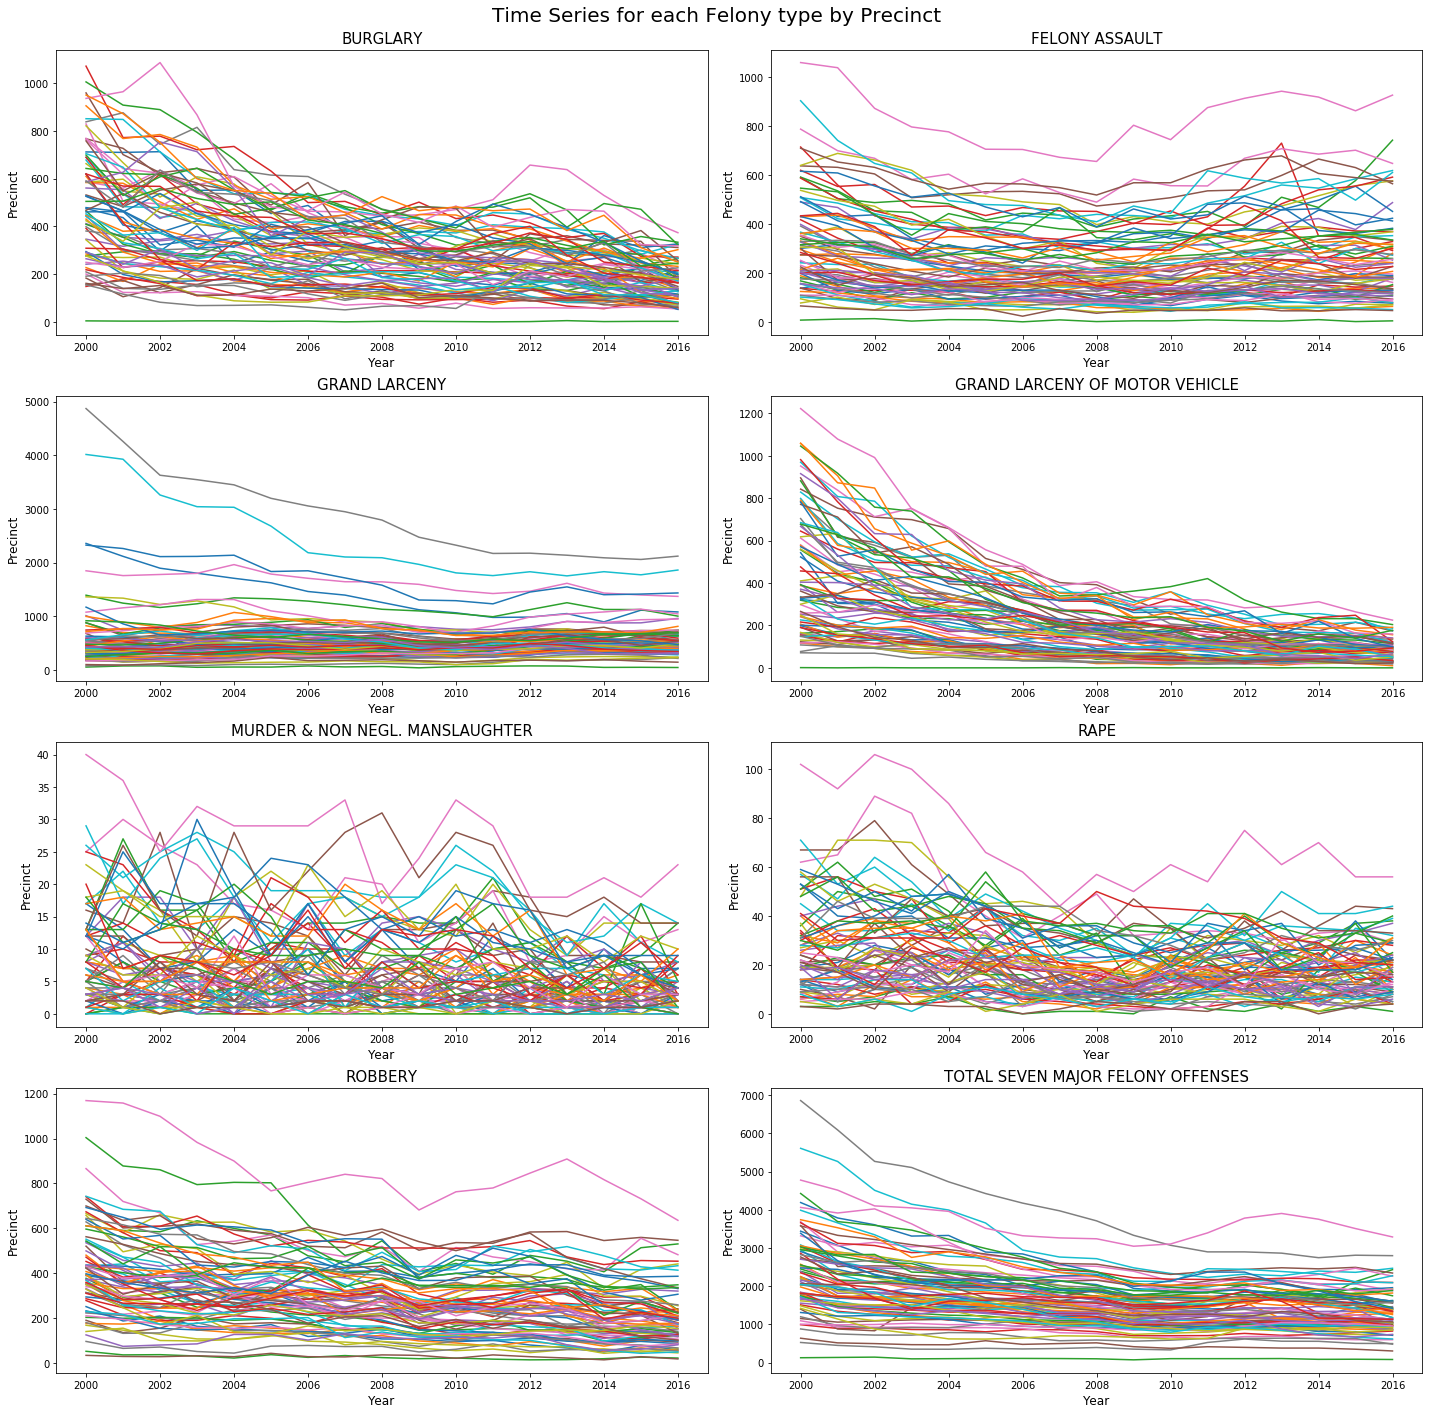

In [18]:
#Plotting same time series as in Figure 2 again to if check the data look fine after dropping the Precinct 121
fig = plt.figure(figsize = (20,20))
fig.suptitle("Time Series for each Felony type by Precinct", fontsize=20)

for i, (crime_name,group) in enumerate(crime.groupby(crime["CRIME"])): 
    ax = plt.subplot(4,2,(i+1))
    group = group.drop(["CRIME", "PCT"], axis = 1).T
    ax.set_xlabel("Year", fontsize = 12)
    ax.set_ylabel("Precinct", fontsize = 12)
    ax.set_title(crime_name, fontsize = 15)
    ax.plot(group)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Figure 3: Time Series (2000 - 2016) for each type of Felony by Precinct

### The above figure is same as the Figure 2 without the Precinct 121.

## 1.4 calculate the mean and standard deviation in time for each precinct and each crime

In [19]:
#Displaying the mean in time for each precinct and each crime
df_group = pd.DataFrame(crime.groupby([crime["PCT"], crime["CRIME"]]).mean())
df_group.mean(axis = 1)

PCT    CRIME                            
1.0    BURGLARY                              242.176471
       FELONY ASSAULT                        104.882353
       GRAND LARCENY                        1406.705882
       GRAND LARCENY OF MOTOR VEHICLE         81.470588
       MURDER & NON NEGL. MANSLAUGHTER         1.058824
       RAPE                                    8.588235
       ROBBERY                               125.705882
       TOTAL SEVEN MAJOR FELONY OFFENSES    1970.588235
5.0    BURGLARY                              152.941176
       FELONY ASSAULT                        130.941176
       GRAND LARCENY                         616.823529
       GRAND LARCENY OF MOTOR VEHICLE         45.882353
       MURDER & NON NEGL. MANSLAUGHTER         1.882353
       RAPE                                    7.529412
       ROBBERY                               147.058824
       TOTAL SEVEN MAJOR FELONY OFFENSES    1103.058824
6.0    BURGLARY                              225.588235
       

In [20]:
#Displaying the standard deviation in time for each precinct and each crime
df_group.std(axis = 1)

PCT    CRIME                            
1.0    BURGLARY                             107.459431
       FELONY ASSAULT                        28.676825
       GRAND LARCENY                        440.662536
       GRAND LARCENY OF MOTOR VEHICLE        53.396065
       MURDER & NON NEGL. MANSLAUGHTER        0.966345
       RAPE                                   3.063063
       ROBBERY                               56.514118
       TOTAL SEVEN MAJOR FELONY OFFENSES    674.856379
5.0    BURGLARY                              57.669826
       FELONY ASSAULT                        28.560179
       GRAND LARCENY                         79.120348
       GRAND LARCENY OF MOTOR VEHICLE        34.521519
       MURDER & NON NEGL. MANSLAUGHTER        1.317306
       RAPE                                   3.429972
       ROBBERY                               67.217437
       TOTAL SEVEN MAJOR FELONY OFFENSES    233.630443
6.0    BURGLARY                              73.271805
       FELONY ASSAULT   

In [21]:
#Clubbing both the mean and standard deviation together in a single dataframe called df_mean_std
df_mean_std = pd.DataFrame({"mean":crime.set_index(["PCT","CRIME"]).mean(axis=1),
                            "std":crime.set_index(["PCT","CRIME"]).std(axis=1)})
df_mean_std.head(8)

mean         std
PCT CRIME                                                     
1.0 MURDER & NON NEGL. MANSLAUGHTER       1.058824    0.966345
    RAPE                                  8.588235    3.063063
    ROBBERY                             125.705882   56.514118
    FELONY ASSAULT                      104.882353   28.676825
    BURGLARY                            242.176471  107.459431
    GRAND LARCENY                      1406.705882  440.662536
    GRAND LARCENY OF MOTOR VEHICLE       81.470588   53.396065
    TOTAL SEVEN MAJOR FELONY OFFENSES  1970.588235  674.856379

### EC1 - you can do a quantitative analysis of these time series (trends, periodicity etc.). But I recommend you only do it after you proceed to the other mandatory tasks. 

## 1.5 extract the total crime row for each precinct and cluster the time series. Plot the clusters and discuss the clustering and the trends that you see. 
(as done in HW10 and 11, see [tips on clustering](https://github.com/fedhere/PUI2017_fb55/blob/master/final/preprocessinANDclustering.ipynb))
I am not looking for a particularly rigorous clustering analysis here, so you do not need to obsess over the right number of clusters for example, or the exact density for DBscan. However, once the clusters are done, visualize them, and make sure that they are convincing clusters that do display homogeneous trends that are different for the different clusters.

In [22]:
#extracting the total crime row for each precinct
crime_total= crime.groupby([crime["PCT"], crime["CRIME"]],
                           as_index = False).apply(lambda df: 
                                                   df[df.CRIME == "TOTAL SEVEN MAJOR FELONY OFFENSES"]).reset_index(False)
totcrime = crime_total.drop("level_0", axis = 1)
totcrime.head(3)

PCT                              CRIME    2000    2001    2002    2003  \
7   1.0  TOTAL SEVEN MAJOR FELONY OFFENSES  3438.0  3069.0  2715.0  2649.0   
15  5.0  TOTAL SEVEN MAJOR FELONY OFFENSES  1780.0  1458.0  1309.0  1231.0   
23  6.0  TOTAL SEVEN MAJOR FELONY OFFENSES  2387.0  2141.0  2059.0  2068.0   

      2004    2005    2006    2007    2008    2009    2010    2011    2012  \
7   2383.0  2305.0  2013.0  1914.0  1708.0  1578.0  1445.0  1402.0  1416.0   
15  1170.0  1131.0  1040.0  1031.0  1029.0   975.0   969.0   962.0  1001.0   
23  2174.0  2055.0  1979.0  1837.0  1738.0  1633.0  1530.0  1504.0  1574.0   

    2013  2014  2015  2016  
7   1416  1208  1446  1395  
15   980   870   917   899  
23  1703  1575  1521  1388

In [23]:
#Fetching the numeric data from the totcrime dataframe and storing it as totcrime_numeric(for clustering)
totcrime["PCT"] = totcrime["PCT"].apply(str)
totcrime_numeric = totcrime._get_numeric_data()

In [24]:
#Preprocessing the data
totcrime_scaled = preprocessing.scale(totcrime_numeric, axis=1)
totcrime_scaled.std(axis=0), totcrime_scaled.std(axis=1)

(array([ 0.52657616,  0.53169654,  0.56004165,  0.47885947,  0.46607783,
         0.42896498,  0.44382541,  0.34588639,  0.33307299,  0.36311809,
         0.30055413,  0.45192942,  0.50667509,  0.58757745,  0.51670076,
         0.55289525,  0.67730601]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [25]:
#checking the columns name of the dataframe
totcrime_numeric.columns

Index([u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007',
       u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015',
       u'2016'],
      dtype='object')

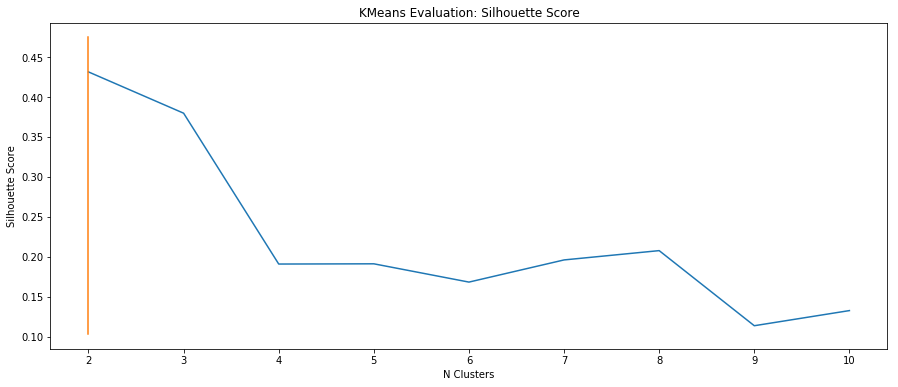

In [26]:
#Reference for the Code: ADS lab on KMeans Clustering

# Calculate silhouette scores for a range of cluster sizes
x_clusters = np.arange(2, 11)
sil_scores = [
    silhouette_score(totcrime_scaled, cluster.KMeans(n, random_state=123).fit(totcrime_scaled).labels_)
    for n in x_clusters
]

# Select the cluster size with the highest silhouette score
best_cluster_size = x_clusters[np.argmax(sil_scores)]

# Visualize silhouette scores
plt.figure(figsize=(15,6))
plt.plot(x_clusters, sil_scores)
plt.plot((best_cluster_size, best_cluster_size), (np.min(sil_scores) / 1.1, np.max(sil_scores) * 1.1))
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

## Figure 4: Evaluating Kmeans using Silhouette Score to find the optimum number of clusters to use

### The above Figure shows that the silhouette score is highest for number of clusters = 2, but since that is quite a low number (might be just overfitting the whole data into 2 clusters) and would not give any useful interpretations for the data, I am using 5 as the optimum number of clusters. 8 could also be an optimum number but that would disintegrate the data into too many clusters. 5 seems as an optimum choice as its score is not low.

In [27]:
# K-Means clustering: the essential parameter is the number of clusters , which I am keep as 5
Nc = 5
km = cluster.KMeans(n_clusters=Nc, random_state=123)
km.fit(totcrime_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [28]:
#Showing the labels
km.labels_

array([3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 4, 3, 3, 3, 3, 4,
       2, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 2, 4, 1, 1, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 1, 3, 3], dtype=int32)

In [29]:
#showing the cluster centers
km.cluster_centers_

array([[ 0.98206706, -0.36159048, -0.25961739,  1.01897146,  0.93617022,
         0.77232423,  0.61584903,  0.0067275 , -0.03289237, -1.28168383,
        -1.16790403, -1.74970775, -0.20849325,  0.56750409,  0.07638679,
         0.36212397, -0.27623524],
       [ 2.45802457,  1.45392545,  1.08484814,  0.58751959,  0.3597    ,
         0.23583878, -0.02892719, -0.30844891, -0.4190353 , -0.9552954 ,
        -0.74215766, -0.53946201, -0.14474713, -0.26067738, -0.58720711,
        -0.85674088, -1.33715755],
       [ 1.77478236,  0.24471967, -0.0596111 , -0.49237251, -0.654315  ,
        -0.50913189, -0.72970485, -0.66548952, -0.51193033, -0.85255695,
        -0.88605647,  0.40105566,  1.31126215,  1.75243542,  0.42617579,
        -0.22995793, -0.3193045 ],
       [ 2.09819754,  1.38733218,  1.19783494,  0.92917936,  0.78210925,
         0.52658525,  0.25744849, -0.07433789, -0.22542912, -0.70416562,
        -0.81308824, -0.80674659, -0.73306533, -0.81814609, -0.98222747,
        -0.97953505

In [30]:
#storing the years in a timeline variable
timeline = list(range(2000, 2017))

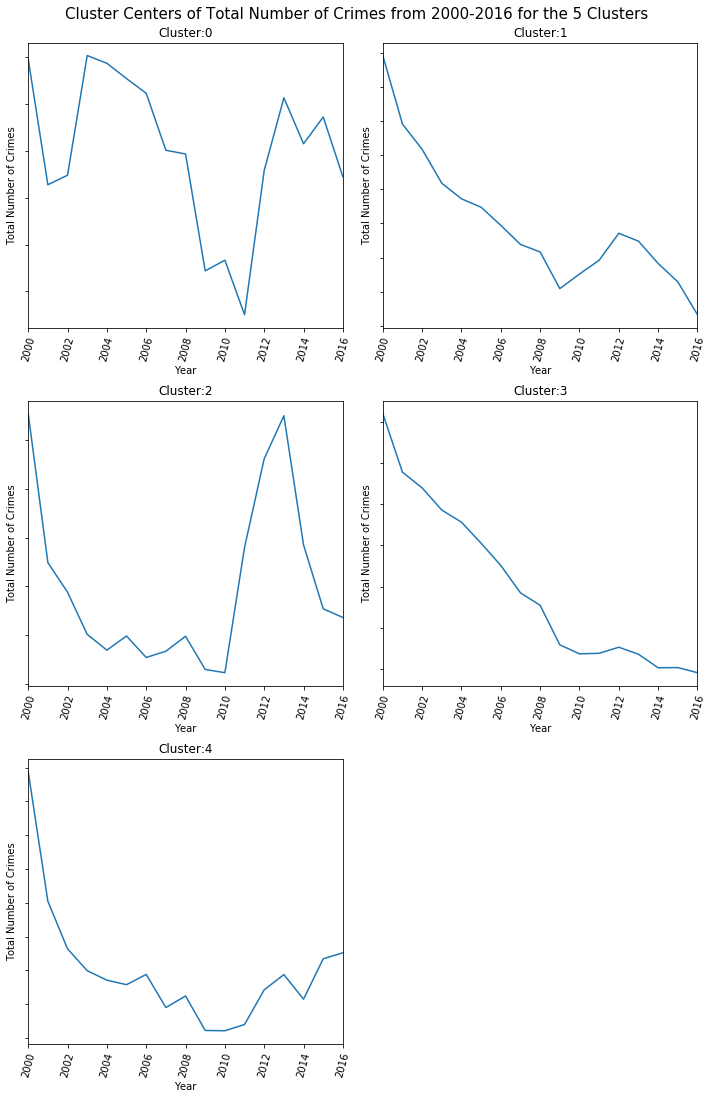

In [31]:
#Reference from the code: From Federica's notebook
#Plotting the Cluster centers
fig = plt.figure(figsize=(10, 25))
cluster_number = 0
fig.suptitle("Cluster Centers of Total Number of Crimes from 2000-2016 for the 5 Clusters", fontsize=15)
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5, 2, (i + 1))
    ax.plot(timeline, Xc)
    ax.set_title("Cluster:{}".format(cluster_number))
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Number of Crimes")
    plt.xticks(fontsize=10, rotation=75)
    plt.xlim([min(timeline), max(timeline)])
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    cluster_number+=1
fig.tight_layout()
fig.subplots_adjust(top=0.96)

## Figure 5: Cluster Centers of the Total Number of Crimes from 2000-2016 for the 5 Clusters

### The above figure shows that overall cluster centers have a decreasing trend, except for cluster 0 and 2, which shows abrupt behaviour from 2011 and 2010 respectively (that is first increase suddenly and then decrease)

In [32]:
#Reference for the code: Ben Steers HW11 GitHub Repo

def plot_clusters(X, labels, ncols=2, title='Total Number of Crimes'):
    """
    This function takes the preprocessed data as X, cluster labels as input and outputs cluster plots
    and prints cluster proportion when called.It also takes ncols and title as function parameters 
    in the function definitions andstores an integer and string value respectively in it.
    
    """
    cluster_size = np.max(labels) + 1 # adjust zero-based
    print(pd.DataFrame(labels, columns=['cluster proportion']).groupby('cluster proportion').size() / X.shape[0])
    
    plt.figure(figsize=(15, 10))
    for i in range(cluster_size):
        plt.subplot(np.ceil(cluster_size / float(ncols)), ncols, i+1)
        plt.plot(timeline, X[labels == i,:].T, linewidth=3, alpha=0.4, c='k')
        plt.plot(timeline, X[labels == i,:].mean(axis=0), linewidth=3)
        
        plt.title('{}: Cluster {} ({} samples)'.format(title, i, (labels == i).sum()))
        plt.xlabel('year')
        plt.ylabel(title)
        plt.xlim([min(timeline), max(timeline)])
        plt.yticks([])
    plt.tight_layout()

cluster proportion
0    0.039474
1    0.263158
2    0.026316
3    0.578947
4    0.092105
dtype: float64


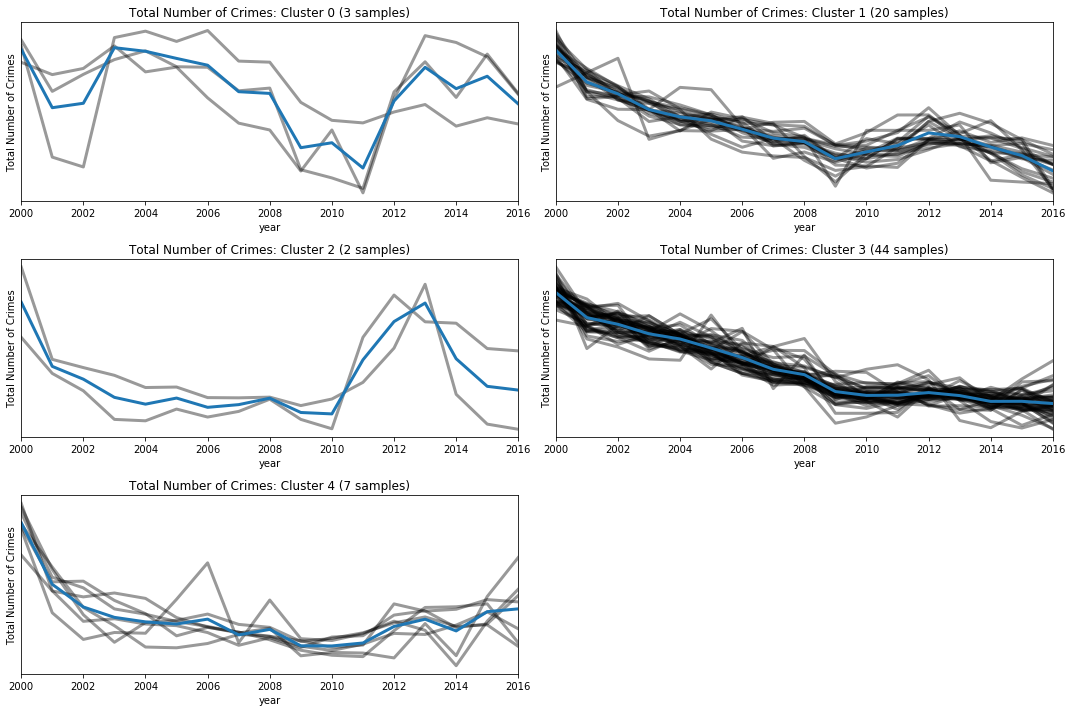

In [33]:
#Calling the function to plot the time series clusters
plot_clusters(totcrime_scaled, km.labels_)

## Figure 6: Time Series cluster plots (2000 - 2016) for total number of crimes.

### The figure shows that cluster 1 and 3 have a decreasing trend, that is decreasing number of crime, whereas cluster 0 and 2 have abrupt behaviour after 2011 and 2010 respectively (first the number of crimes decrease and then increase after 2011 and 2010 for cluster 0 and 2 respectively).


In [34]:
#Storing the cluster labels in the totcrime_numeric dataframe
totcrime_numeric['clusters'] = km.labels_
totcrime_numeric.head(10)

2000    2001    2002    2003    2004    2005    2006    2007    2008  \
7   3438.0  3069.0  2715.0  2649.0  2383.0  2305.0  2013.0  1914.0  1708.0   
15  1780.0  1458.0  1309.0  1231.0  1170.0  1131.0  1040.0  1031.0  1029.0   
23  2387.0  2141.0  2059.0  2068.0  2174.0  2055.0  1979.0  1837.0  1738.0   
31   990.0   892.0   908.0   864.0   857.0   804.0   864.0   856.0   807.0   
39  2115.0  1672.0  1809.0  1801.0  1747.0  1664.0  1579.0  1519.0  1495.0   
47  1398.0   877.0   831.0  1436.0  1466.0  1418.0  1469.0  1326.0  1321.0   
55  3317.0  3054.0  3145.0  3031.0  3071.0  2812.0  2716.0  2540.0  2518.0   
63  6857.0  6088.0  5265.0  5105.0  4730.0  4423.0  4173.0  3971.0  3708.0   
71  2028.0  1990.0  1801.0  1796.0  1667.0  1397.0  1391.0  1277.0  1269.0   
79  5607.0  5263.0  4508.0  4144.0  3992.0  3652.0  2945.0  2761.0  2718.0   

      2009    2010    2011    2012  2013  2014  2015  2016  clusters  
7   1578.0  1445.0  1402.0  1416.0  1416  1208  1446  1395         3  
15   975.0   969.0   962.0  1001.0   980   870   917   899         1  
23  1633.0  1530.0  1504.0  1574.0  1703  1575  1521  1388         3  
31   702.0   702.0   704.0   762.0   711   732   781   823         3  
39  1523.0  1387.0  1350.0  1419.0  1424  1331  1337  1463         3  
47  1133.0  1049.0  1037.0  1088.0  1123  1022  1061  1032         0  
55  2389.0  2136.0  2044.0  2022.0  2152  2061  2056  1879         3  
63  3330.0  3069.0  2896.0  2896.0  2863  2744  2809  2797         3  
71  1018.0   990.0   937.0  1020.0  1024   909   986  1000         3  
79  2479.0  2331.0  2228.0  2313.0  2271  2394  2361  2467         3

# Part 2: connecting the temporal and spatial components.
## 2.1 obtain the NYC precincts geometry and read it in as a shapefile           
(see [the data tips](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_DATA.ipynb))

In [35]:
#setting up data_dir (data directory) for the shapefile and getting the shapefile link
data_dir = os.getenv('PUIDATA', './')
shp_url = "https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile"
shp_fname = os.path.join(data_dir, 'nyc-precinct-shp')

In [36]:
## Load Zip Code Shapefile.
# download if it doesn't exist
if not os.path.exists(shp_fname):
    print('downloading', shp_url)
    zipfile.ZipFile(io.BytesIO( requests.get(shp_url).content )).extractall(shp_fname)

# Read in shapefile
gdf_full = gpd.read_file(shp_fname)
gdf_full.head()

precinct    shape_leng    shape_area  \
0       1.0  80586.154615  4.730176e+07   
1       5.0  18676.124259  1.808880e+07   
2       6.0  27182.610113  2.213193e+07   
3       7.0  17301.308682  1.836402e+07   
4       9.0  19773.233410  2.139423e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

## 2.2 merge the precincts geodataframe with the dataframe of crime that you used to cluster the time series and plot a choropleth of the clusters. 
Discuss if you see spatial coherence - does the geographical information help interpret the trends you see in time domain?

In [37]:
#Renaming the precinct to PCT for easy merging later
gdf_full = gdf_full.rename(columns={'precinct': 'PCT'})

In [38]:
#making sure the PCT name column is a string and identical so that there is no problem in merging later
totcrime["PCT"] = totcrime["PCT"].apply(str)
gdf_full["PCT"] = gdf_full["PCT"].apply(str)

In [39]:
#checking the dataframe format
gdf_full.head()

PCT    shape_leng    shape_area  \
0  1.0  80586.154615  4.730176e+07   
1  5.0  18676.124259  1.808880e+07   
2  6.0  27182.610113  2.213193e+07   
3  7.0  17301.308682  1.836402e+07   
4  9.0  19773.233410  2.139423e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

In [40]:
#merging the gdf_full and totcrime and dropping "CRIME" columns
gdf_crime_precinct = GeoDataFrame(pd.merge(gdf_full, totcrime, on='PCT'))
gdf_crime_precinct = gdf_crime_precinct.drop("CRIME", axis = 1)
gdf_crime_precinct.head()

PCT    shape_leng    shape_area  \
0  1.0  80586.154615  4.730176e+07   
1  5.0  18676.124259  1.808880e+07   
2  6.0  27182.610113  2.213193e+07   
3  7.0  17301.308682  1.836402e+07   
4  9.0  19773.233410  2.139423e+07   

                                            geometry    2000    2001    2002  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...  3438.0  3069.0  2715.0   
1  POLYGON ((-73.98863862848766 40.72293372026369...  1780.0  1458.0  1309.0   
2  POLYGON ((-73.99968392160721 40.73855224865976...  2387.0  2141.0  2059.0   
3  POLYGON ((-73.97345389423181 40.718962954076, ...   990.0   892.0   908.0   
4  POLYGON ((-73.97160900246391 40.72672340116989...  2115.0  1672.0  1809.0   

     2003    2004    2005  ...     2007    2008    2009    2010    2011  \
0  2649.0  2383.0  2305.0  ...   1914.0  1708.0  1578.0  1445.0  1402.0   
1  1231.0  1170.0  1131.0  ...   1031.0  1029.0   975.0   969.0   962.0   
2  2068.0  2174.0  2055.0  ...   1837.0  1738.0  1633.0  1530.0  1504.0   
3   864.0   857.0   804.0  ...    856.0   807.0   702.0   702.0   704.0   
4  1801.0  1747.0  1664.0  ...   1519.0  1495.0  1523.0  1387.0  1350.0   

     2012  2013  2014  2015  2016  
0  1416.0  1416  1208  1446  1395  
1  1001.0   980   870   917   899  
2  1574.0  1703  1575  1521  1388  
3   762.0   711   732   781   823  
4  1419.0  1424  1331  1337  1463  

[5 rows x 21 columns]

In [41]:
#storing cluster labels as kmcluster column in the merged dataframe
gdf_crime_precinct['kmcluster'] = km.labels_

In [42]:
#checking means of every cluster
gdf_crime_precinct.drop(["shape_leng","shape_area","PCT","geometry"], axis=1).groupby(["kmcluster"]).mean().mean(axis=1)

kmcluster
0    1066.019608
1    1661.526471
2     903.647059
3    1734.871658
4    1658.445378
dtype: float64

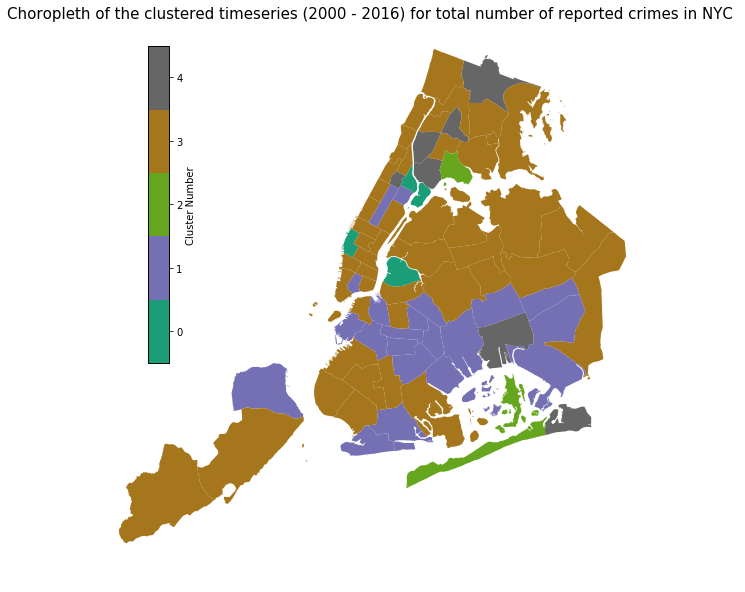

In [43]:
f, ax, cb = cp.choroplethNYC(gdf_crime_precinct, 'kmcluster', kind='discrete', cmap='Dark2')
cb.set_label("Cluster Number", fontsize = 10)
ax.set_title('Choropleth of the clustered timeseries (2000 - 2016) for total number of reported crimes in NYC ', fontsize = 15);

## Figure 7: Choropleth of the clustered timeseries (2000 - 2016) for total number of reported crimes in NYC

### The above chloropleth uses Kmeans clustering method. The means of the clusters are: 
#### 0    1066.019608
#### 1    1661.526471
#### 2     903.647059
#### 3    1734.871658
#### 4    1658.445378

### Referring to the means of the clusters (listed above), Cluster 3 and and 4 have the highest number of crimes, whereas the cluster 2 has the lowest. The chloropleth above shows that Manhatan and Bronx have higher number of crimes than center-Brooklyn and lower Queens area. The area near Central Park also has lower number of crimes.

### EC2 visualize each crime by precinct. here you can choose the visual display that you prefer, but not a time series plot (like you did before) or a coropleth (like you will do later). It could be a box and whiskers plot for example

## 2.3 download the data containing the socioeconomic features to be used as exogenous variables. 
I prepared a file with socioeconomic features for each precinct: unemployed fraction, median income, fraction of the precinct area that is green. Dowload it from https://nyu.carto.com via sql (HW 7) ( ideally only extracting the relevant columns). The source sql is  'https://fb55.carto.com:443/api/v2/sql?q=' , the name of the file  *nycsocioeconomicsbyprecinct*


In [44]:
#reference for the code: Federica's HW7 notebook
SQL_SOURCE = "https://fb55.carto.com:443/api/v2/sql?q="
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (carto ic1018 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urlencode({'format': format, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [45]:
#downloading socioeconomic data
task2_3 = '''
SELECT precinct, green, medianincome, unemployment FROM nycsocioeconomicsbyprecinct
'''
socioeconomics= pd.read_csv(StringIO(queryCartoDB(task2_3).decode("utf-8")))

In [46]:
#seeing how the socioeconomic dataset looks like
socioeconomics.head()

precinct     green   medianincome  unemployment
0         1  0.058702  124092.068749      0.021444
1        60  0.173512   35015.008703      0.056448
2        61  0.238375   65998.923662      0.055458
3        63  0.158530   33655.205265      0.031215
4        24  0.166040  113966.467973      0.043461

## 2.4 *pivot* the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns 
This task may be the most unfamiliar. look at the hints for an example on how to do it. If this fails you can download the pivoted file [here](https://github.com/fedhere/PUI2017_fb55/blob/master/final/crimepivoted.csv)

In [47]:
#pivoting the crime dataframe
crimepivot = df_group.mean(axis = 1).unstack(1)
crimepivot.head()

CRIME    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
PCT                                                
1.0    242.176471      104.882353    1406.705882   
5.0    152.941176      130.941176     616.823529   
6.0    225.588235      114.352941    1183.000000   
7.0    108.176471      124.411765     317.352941   
9.0    247.882353      169.647059     833.176471   

CRIME  GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER  \
PCT                                                                      
1.0                         81.470588                         1.058824   
5.0                         45.882353                         1.882353   
6.0                         82.117647                         1.294118   
7.0                         74.117647                         2.588235   
9.0                         89.529412                         2.294118   

CRIME       RAPE     ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  
PCT                                                              
1.0     8.588235  125.705882                        1970.588235  
5.0     7.529412  147.058824                        1103.058824  
6.0     9.470588  199.823529                        1815.647059  
7.0    10.705882  172.000000                         809.352941  
9.0    15.470588  208.764706                        1566.764706

## 2.5 merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct
clean up your data so that the only columns left are the 7 felonies, the total number of felonies, and the socioeconomic features (unemployment, median income, park access). I recommend you rename the crime features: the dataframes have very annoying white spaces encoded in them. See the hints file to remove them.

In [48]:
#changing the name of precinct columns to PCT for easy merging later
socioeconomics = socioeconomics.rename(columns={'precinct': 'PCT'})

In [49]:
#changing the name of green to park access (as per written in the 2.5 question:unemployment, median income, park access)
socioeconomics = socioeconomics.rename(columns={'green': 'park access'})

In [50]:
#checking the socioeconomic dataframe
socioeconomics.head()

PCT  park access   medianincome  unemployment
0    1     0.058702  124092.068749      0.021444
1   60     0.173512   35015.008703      0.056448
2   61     0.238375   65998.923662      0.055458
3   63     0.158530   33655.205265      0.031215
4   24     0.166040  113966.467973      0.043461

In [51]:
#merging socioeconomic and crimepivot
df_crime_socio = pd.merge(socioeconomics, crimepivot, left_on='PCT', right_index=True)
df_crime_socio.head()

PCT  park access   medianincome  unemployment    BURGLARY  FELONY ASSAULT  \
0    1     0.058702  124092.068749      0.021444  242.176471      104.882353   
1   60     0.173512   35015.008703      0.056448  230.588235      272.529412   
2   61     0.238375   65998.923662      0.055458  445.235294      167.588235   
3   63     0.158530   33655.205265      0.031215  249.235294      153.588235   
4   24     0.166040  113966.467973      0.043461  162.411765      137.705882   

   GRAND LARCENY  GRAND LARCENY OF MOTOR VEHICLE  \
0    1406.705882                       81.470588   
1     519.823529                      151.705882   
2     678.294118                      310.411765   
3     593.294118                      252.176471   
4     568.117647                       91.470588   

   MURDER & NON NEGL. MANSLAUGHTER       RAPE     ROBBERY  \
0                         1.058824   8.588235  125.705882   
1                         7.705882  18.470588  332.529412   
2                         5.352941  13.235294  269.529412   
3                         5.000000  12.529412  242.058824   
4                         2.647059  12.764706  237.705882   

   TOTAL SEVEN MAJOR FELONY OFFENSES  
0                        1970.588235  
1                        1533.352941  
2                        1889.647059  
3                        1507.882353  
4                        1212.823529

In [52]:
#making sure the data type of PCT is same for df_crime_socio and gdf_full for merging later
df_crime_socio["PCT"] = df_crime_socio["PCT"].apply(float)
gdf_full["PCT"] = gdf_full["PCT"].apply(float)
gdf_full["PCT"].dtypes == df_crime_socio["PCT"].dtypes

True

In [53]:
#merging gdf_full and df_crime_socio
gdf_crime_socio = GeoDataFrame(pd.merge(gdf_full, df_crime_socio, on='PCT'))
gdf_crime_socio.head()

PCT    shape_leng    shape_area  \
0  1.0  80586.154615  4.730176e+07   
1  5.0  18676.124259  1.808880e+07   
2  6.0  27182.610113  2.213193e+07   
3  7.0  17301.308682  1.836402e+07   
4  9.0  19773.233410  2.139423e+07   

                                            geometry  park access  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...     0.058702   
1  POLYGON ((-73.98863862848766 40.72293372026369...     0.049462   
2  POLYGON ((-73.99968392160721 40.73855224865976...     0.035655   
3  POLYGON ((-73.97345389423181 40.718962954076, ...     0.125848   
4  POLYGON ((-73.97160900246391 40.72672340116989...     0.080894   

    medianincome  unemployment    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
0  124092.068749      0.021444  242.176471      104.882353    1406.705882   
1   99148.860914      0.046260  152.941176      130.941176     616.823529   
2  119565.099444      0.029992  225.588235      114.352941    1183.000000   
3   44645.989878      0.052540  108.176471      124.411765     317.352941   
4   82391.812180      0.041264  247.882353      169.647059     833.176471   

   GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER       RAPE  \
0                       81.470588                         1.058824   8.588235   
1                       45.882353                         1.882353   7.529412   
2                       82.117647                         1.294118   9.470588   
3                       74.117647                         2.588235  10.705882   
4                       89.529412                         2.294118  15.470588   

      ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  
0  125.705882                        1970.588235  
1  147.058824                        1103.058824  
2  199.823529                        1815.647059  
3  172.000000                         809.352941  
4  208.764706                        1566.764706

In [54]:
#dropping the non-useful columns
#keeping PCT number because not sure that it may be useful later
gdf_crime_socio = gdf_crime_socio.drop(["shape_leng", "shape_area"], axis = 1)

In [55]:
#seeing how the merged dataframe looks like
gdf_crime_socio.head(10)

PCT                                           geometry  park access  \
0   1.0  (POLYGON ((-74.0438776157395 40.69018767637665...     0.058702   
1   5.0  POLYGON ((-73.98863862848766 40.72293372026369...     0.049462   
2   6.0  POLYGON ((-73.99968392160721 40.73855224865976...     0.035655   
3   7.0  POLYGON ((-73.97345389423181 40.718962954076, ...     0.125848   
4   9.0  POLYGON ((-73.97160900246391 40.72672340116989...     0.080894   
5  10.0  POLYGON ((-74.00138603698601 40.76285009500188...     0.018457   
6  13.0  POLYGON ((-73.98155997085217 40.74388188334704...     0.032087   
7  14.0  POLYGON ((-73.97464798076284 40.75336712262782...     0.022124   
8  17.0  (POLYGON ((-73.96421230395677 40.7466043184766...     0.017766   
9  18.0  POLYGON ((-73.99393666655916 40.77317984583595...     0.013054   

    medianincome  unemployment    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
0  124092.068749      0.021444  242.176471      104.882353    1406.705882   
1   99148.860914      0.046260  152.941176      130.941176     616.823529   
2  119565.099444      0.029992  225.588235      114.352941    1183.000000   
3   44645.989878      0.052540  108.176471      124.411765     317.352941   
4   82391.812180      0.041264  247.882353      169.647059     833.176471   
5  126699.796468      0.048472  128.058824      120.647059     699.764706   
6  119416.032096      0.038981  367.941176      170.294118    1630.117647   
7  133690.008536      0.034299  514.764706      215.882353    2899.823529   
8  113300.273058      0.024535  167.941176       71.882353     932.235294   
9  107075.627079      0.033543  311.176471      168.352941    2406.941176   

   GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER       RAPE  \
0                       81.470588                         1.058824   8.588235   
1                       45.882353                         1.882353   7.529412   
2                       82.117647                         1.294118   9.470588   
3                       74.117647                         2.588235  10.705882   
4                       89.529412                         2.294118  15.470588   
5                       78.058824                         2.176471  10.470588   
6                      107.294118                         2.000000  14.470588   
7                       44.941176                         2.705882  12.705882   
8                       51.647059                         0.647059   9.058824   
9                       87.823529                         2.176471  13.705882   

      ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  
0  125.705882                        1970.588235  
1  147.058824                        1103.058824  
2  199.823529                        1815.647059  
3  172.000000                         809.352941  
4  208.764706                        1566.764706  
5  142.411765                        1181.588235  
6  233.941176                        2526.058824  
7  292.941176                        3983.764706  
8   90.117647                        1323.529412  
9  211.823529                        3202.000000

In [56]:
#storing the crime (felony) type in columns variable
columns = gdf_crime_socio.columns
columns = columns.drop(["geometry", "PCT", "park access", "medianincome", "unemployment"])
columns

Index([u'BURGLARY', u'FELONY ASSAULT', u'GRAND LARCENY',
       u'GRAND LARCENY OF MOTOR VEHICLE', u'MURDER & NON NEGL. MANSLAUGHTER',
       u'RAPE', u'ROBBERY', u'TOTAL SEVEN MAJOR FELONY OFFENSES'],
      dtype='object')

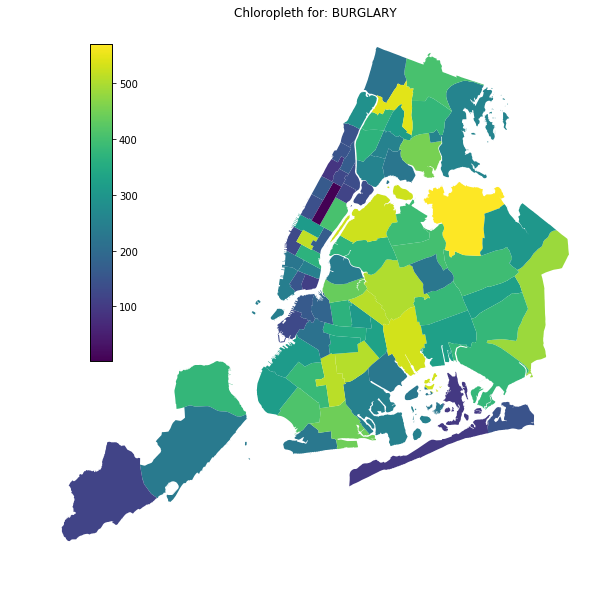

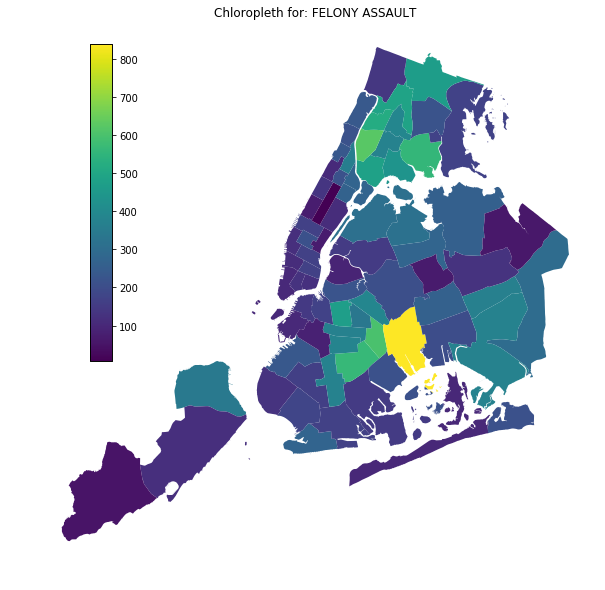

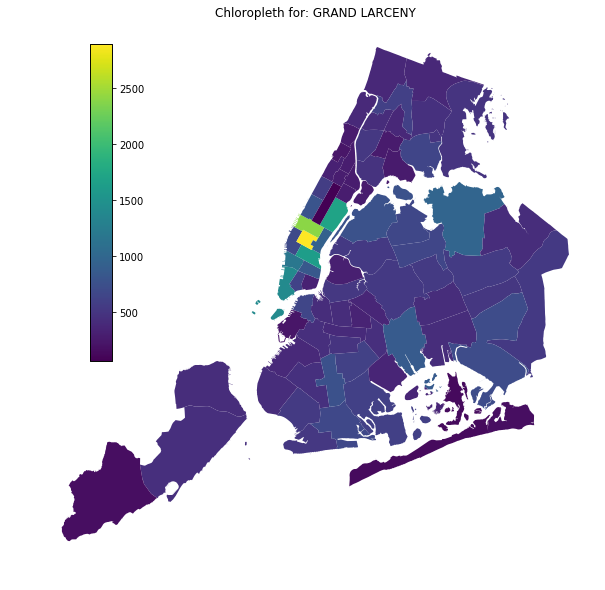

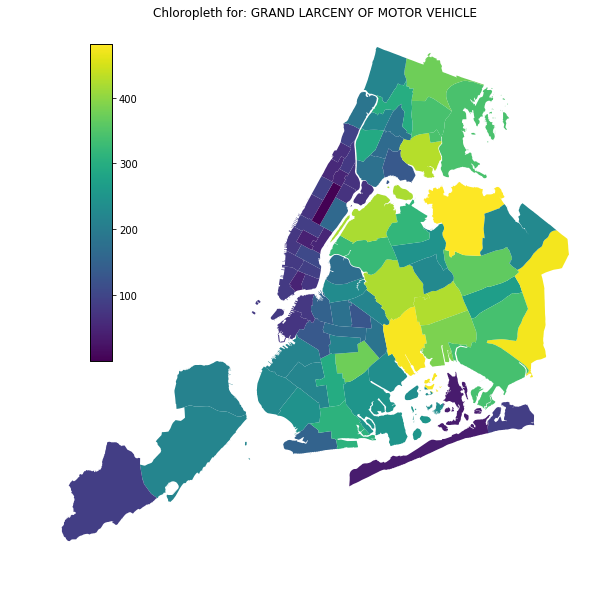

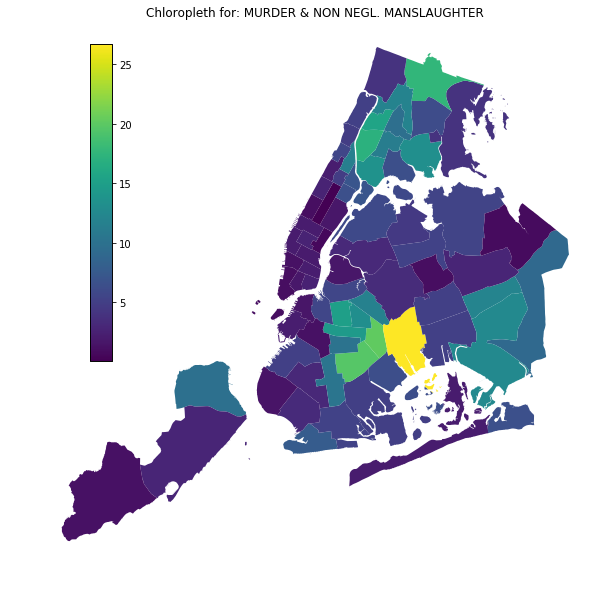

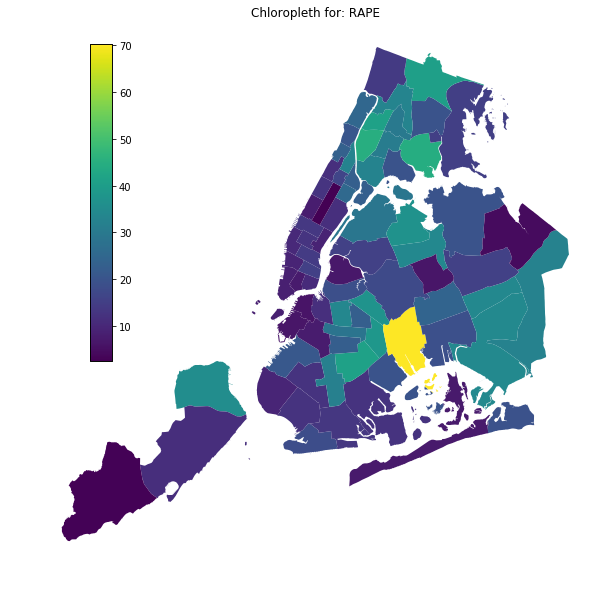

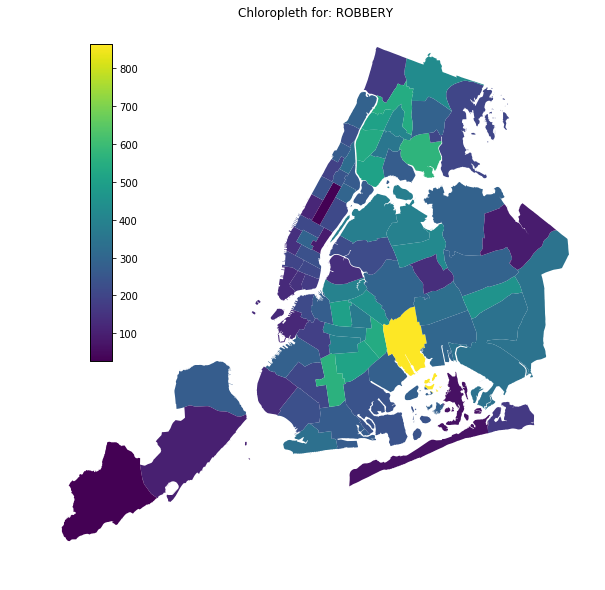

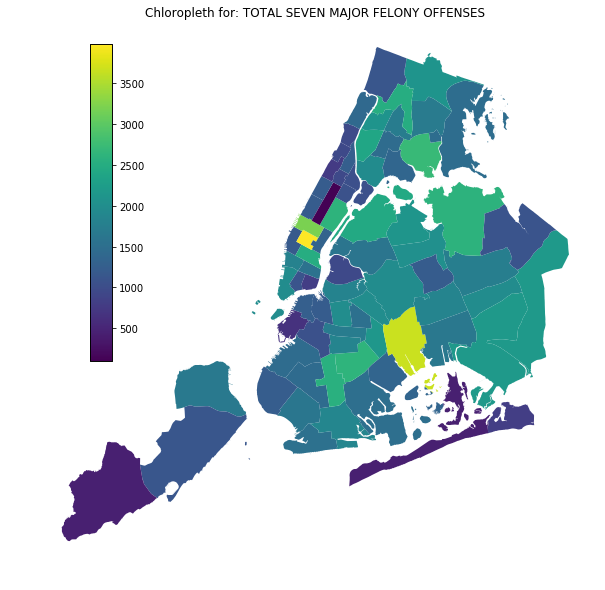

In [57]:
#ploting chloropleth of each of the 7 felonies, plus the total crime by precinct
for i in columns:
    fig, ax, cb= cp.choroplethNYC(gdf_crime_socio, column=i);
    ax.set_title("Chloropleth for: {}".format(i))

## Figure 8: Chloropleth showing the average number of crimes over all years (2000 - 2016) for each of the 7 felonies, plus the total crime by precinct

### For Burglary: There are more number of crimes in Bronx and upper Queen and middle Brooklyn.

### For Felony Assault: The over number of crimes is usually low except area joining lower Queens and north east Brooklyn around Ozone Park.

### For Grand Larceny, it is usually low except in Downtown Manhattan area, which is probably because of high property cost in that area (personal property, bank money etc.).

### For Grand Larceny of Motor Vehicle: It is pretty much everywhere (specifically Queens) apart from Manhattan. It is probably lower in Manhattan because not many people travel by personal vehicle there, and rather take public transport there (It is usually difficult to drive there).

### For Murder and Non Negl. Manslaughter: It is usually low except the Ozone Park area (lower Queens) and upper Bronx.

### For Rape: It is higher in Queens specifically in Ozone Park area and upper Brooklyn and Bronx area.

### For Robbery: It is higher in Ozone Park area and Bronx.

### Overall: The number of crimes are overall highers in Ozone Park area in Queens, upper Queens, south Bronx, center Brooklyn and in downtown Manhattan (majorly due to Grand Larceny).

## 2.6 cluster the data first using the socioeconomic features and then using the 7 felonies 
You can use a simple Euclidean distance, since these are all numerical features, which is the default for most packages, or define your distance. if you do that, which would be exciting, please justify your distance definition. Mind the preprocessing! Do the clusters make sense?, is the grouping preserved? are the outliers outliers in both clustering schemes?

In [58]:
#preprocessing the data
cluster_socio = gdf_crime_socio[["park access", "medianincome", "unemployment"]]
clustersocio_scaled = preprocessing.scale(cluster_socio, axis=0)
clustersocio_scaled.std(axis=0), clustersocio_scaled.std(axis=1)

(array([ 1.,  1.,  1.]),
 array([ 1.25094683,  0.71380348,  1.13304819,  0.2071481 ,  0.5007939 ,
         1.11371841,  1.05938126,  1.29645629,  1.12733296,  0.97517042,
         1.43753639,  1.2293344 ,  3.66418502,  0.48492908,  0.80985694,
         1.05024404,  0.80774422,  0.76322717,  0.10396558,  0.8291992 ,
         0.42981468,  0.82212385,  0.97861507,  0.79251964,  1.00729492,
         0.68424402,  0.81778566,  1.15349848,  0.95128002,  0.61411198,
         1.07860306,  0.46090348,  1.04958143,  1.02476759,  0.45560965,
         0.43430725,  0.26322717,  0.54006905,  0.14456257,  0.57479704,
         0.31914014,  0.44391207,  0.26192255,  0.66900793,  0.1523029 ,
         0.88179473,  0.68325296,  0.63955569,  0.36045106,  1.07066997,
         0.57921748,  0.76242906,  0.72277957,  1.11387272,  0.55317828,
         0.3235796 ,  0.42532184,  0.35133907,  0.59095265,  0.38956129,
         0.9843903 ,  0.47801401,  0.1107628 ,  0.30028578,  0.22471216,
         0.28081045,  0.24

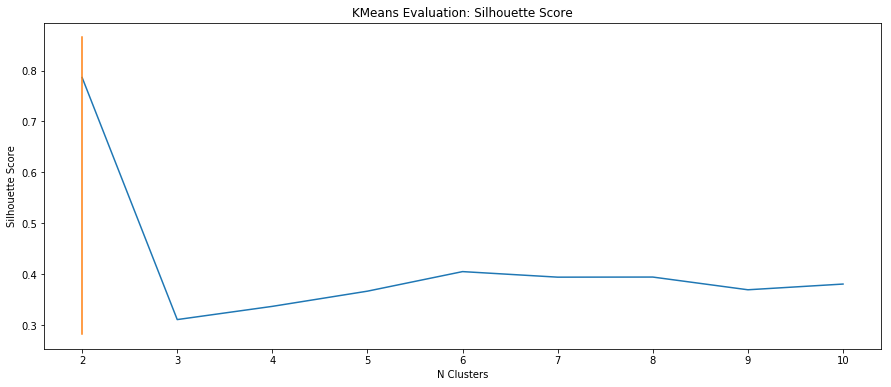

In [59]:
# Calculate silhouette scores for a range of cluster sizes
x_clusters = np.arange(2, 11)
sil_scores = [
    silhouette_score(clustersocio_scaled, cluster.KMeans(n,random_state=123).fit(clustersocio_scaled).labels_)
    for n in x_clusters
]

# Select the cluster size with the highest silhouette score
best_cluster_size = x_clusters[np.argmax(sil_scores)]
#print('The best silhouette score is at: {} clusters'.format(best_cluster_size))

# Visualize silhouette scores
plt.figure(figsize=(15,6))
plt.plot(x_clusters, sil_scores)
plt.plot((best_cluster_size, best_cluster_size), (np.min(sil_scores) / 1.1, np.max(sil_scores) * 1.1))
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

## Figure 9: Evaluating Kmeans using Silhouette Score to find the optimum number of clusters to use

### The above Figure shows that the silhouette score is highest for number of clusters = 2, but since that is quite a low number (might be just overfitting the whole data into 2 clusters) and would not give any useful interpretations for the data, I am using 5 as the optimum number of clusters as I have used the same number before and thus mantaining the consistency for comparson. 6 could also be an optimum number.

In [60]:
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 5
ksocio = cluster.KMeans(n_clusters=Nc, random_state=123)
ksocio.fit(clustersocio_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [61]:
ksocio.cluster_centers_

array([[ 1.30016226, -0.36285735, -0.04544834],
       [-0.42850004,  1.63799921, -0.64062065],
       [-0.41406954, -0.92839669,  0.70766276],
       [ 6.18299903, -1.59246107,  6.17789676],
       [-0.25877775,  0.05457566, -0.37300286]])

In [62]:
ksocio.labels_

array([1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 0, 0, 1, 4, 2, 0, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2,
       2, 1, 4, 0, 2, 2, 2, 1, 4, 4, 4, 4, 0, 4, 2, 4, 4, 4, 4, 4, 4, 0, 4,
       4, 2, 4, 4, 4, 4, 4], dtype=int32)

In [63]:
cluster_socio['clusters'] = ksocio.labels_
cluster_socio.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


park access   medianincome  unemployment  clusters
0     0.058702  124092.068749      0.021444         1
1     0.049462   99148.860914      0.046260         1
2     0.035655  119565.099444      0.029992         1
3     0.125848   44645.989878      0.052540         4
4     0.080894   82391.812180      0.041264         4

In [64]:
gdf_crime_socio["cluster_socio"] = ksocio.labels_
gdf_crime_socio.head()

PCT                                           geometry  park access  \
0  1.0  (POLYGON ((-74.0438776157395 40.69018767637665...     0.058702   
1  5.0  POLYGON ((-73.98863862848766 40.72293372026369...     0.049462   
2  6.0  POLYGON ((-73.99968392160721 40.73855224865976...     0.035655   
3  7.0  POLYGON ((-73.97345389423181 40.718962954076, ...     0.125848   
4  9.0  POLYGON ((-73.97160900246391 40.72672340116989...     0.080894   

    medianincome  unemployment    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
0  124092.068749      0.021444  242.176471      104.882353    1406.705882   
1   99148.860914      0.046260  152.941176      130.941176     616.823529   
2  119565.099444      0.029992  225.588235      114.352941    1183.000000   
3   44645.989878      0.052540  108.176471      124.411765     317.352941   
4   82391.812180      0.041264  247.882353      169.647059     833.176471   

   GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER       RAPE  \
0                       81.470588                         1.058824   8.588235   
1                       45.882353                         1.882353   7.529412   
2                       82.117647                         1.294118   9.470588   
3                       74.117647                         2.588235  10.705882   
4                       89.529412                         2.294118  15.470588   

      ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  cluster_socio  
0  125.705882                        1970.588235              1  
1  147.058824                        1103.058824              1  
2  199.823529                        1815.647059              1  
3  172.000000                         809.352941              4  
4  208.764706                        1566.764706              4

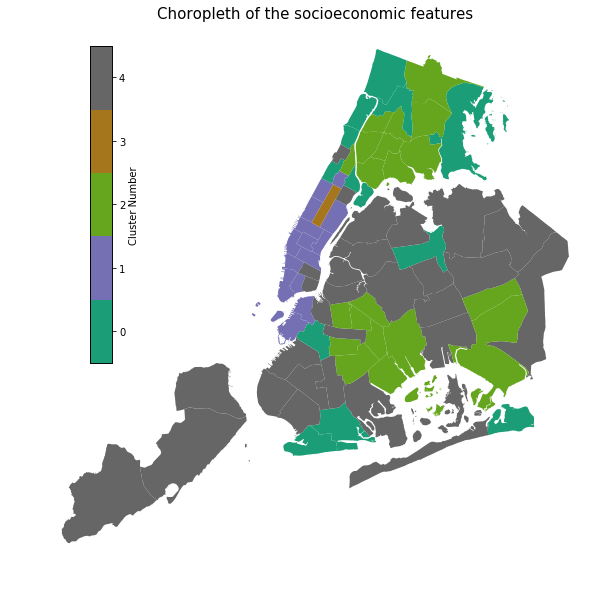

In [65]:
f, ax, cb = cp.choroplethNYC(gdf_crime_socio, 'cluster_socio', kind='discrete', cmap='Dark2')
cb.set_label("Cluster Number", fontsize = 10)
ax.set_title('Choropleth of the socioeconomic features', fontsize = 15);

## Figure 10: NYC Choropleth of the socioeconomic features

### Here the clusters are not entirely similar as crime clusters in Figure 7. However 2 and 4 here is somewhat similar to cluster to 3 and 4 (showing the highest number of crimes) in Figure 7 (there is discrepancy in the two cluster figures for the Manhattan area).

In [66]:
n=2
pca = PCA(n)
Xproj = pca.fit_transform(clustersocio_scaled)
eigenvalues = pca.explained_variance_
print(pca.explained_variance_ratio_.sum())

0.860136810455


In [67]:
cluster_socio.shape

(76, 4)

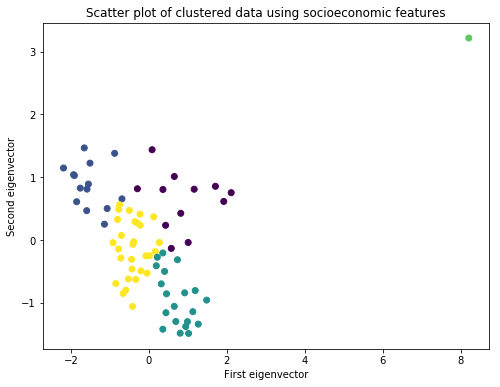

In [68]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Xproj[:, 0], Xproj[:, 1], c= ksocio.labels_)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title("Scatter plot of clustered data using socioeconomic features")
plt.show()

## Figure 11: Scatter plot of clustered data using the socioeconomic features after PCA

### Here eigenvector 1 seems more useful, as most of the data can be fitted along it. There are some outliers from 3 to 6 along the second eigenvector.

In [69]:
cluster_crime = gdf_crime_socio.drop(["geometry", "PCT", "park access", "medianincome", "unemployment",
                                      "TOTAL SEVEN MAJOR FELONY OFFENSES"],axis = 1)
clustercrime_scaled = preprocessing.scale(cluster_crime, axis=0)
clustercrime_scaled.std(axis=0), cluster_crime.std(axis=1)

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 0     475.858844
 1     204.391903
 2     395.996924
 3     107.181548
 4     274.604889
 5     230.620502
 6     546.399377
 7     987.332241
 8     314.871578
 9     818.440501
 10    574.035736
 11    267.276494
 12     21.113959
 13    130.276517
 14    188.592193
 15    125.087006
 16    111.965653
 17    118.902258
 18    109.327848
 19    147.372757
 20    107.451987
 21    149.156123
 22    221.865560
 23    157.983590
 24    153.652938
 25    273.866066
 26    252.754893
 27    175.502328
 28    221.736358
 29    204.566808
          ...    
 46    383.340859
 47     78.651964
 48    179.774887
 49    150.464516
 50    214.200422
 51    163.907887
 52    208.583384
 53    214.808403
 54    146.235875
 55    207.634680
 56    116.724474
 57     50.140058
 58     84.551589
 59    190.536135
 60    205.071108
 61    223.894581
 62    226.771987
 63    176.960834
 64    211.312280
 65    196.090660
 66    340.849524
 67    234.1202

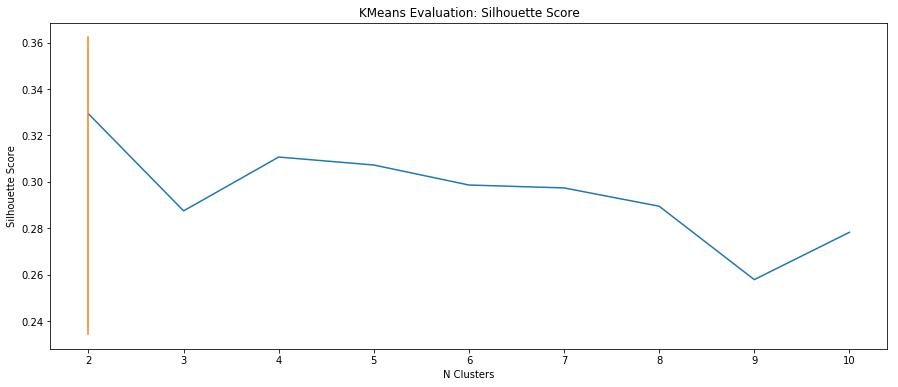

In [70]:
# Calc silhouette scores for a range of cluster sizes
x_clusters = np.arange(2, 11)
sil_scores = [
    silhouette_score(clustercrime_scaled, cluster.KMeans(n, random_state = 123).fit(clustercrime_scaled).labels_)
    for n in x_clusters
]

# Select the cluster size with the highest silhouette score
best_cluster_size = x_clusters[np.argmax(sil_scores)]
#print('The best silhouette score is at: {} clusters'.format(best_cluster_size))

# Visualize silhouette scores
plt.figure(figsize=(15,6))
plt.plot(x_clusters, sil_scores)
plt.plot((best_cluster_size, best_cluster_size), (np.min(sil_scores) / 1.1, np.max(sil_scores) * 1.1))
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

## Figure 12: Evaluating Kmeans using Silhouette Score to find the optimum number of clusters to use

### The above Figure shows that the silhouette score is highest for number of clusters = 3, but since that is quite a low number (might be just overfitting the whole data into 2 clusters) and would not give any useful interpretations for the data, I am using 5 as the optimum number of clusters as it is the next highest number.

In [71]:
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 5
kcrime = cluster.KMeans(n_clusters=Nc, random_state=123)
kcrime.fit(clustercrime_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [72]:
kcrime.cluster_centers_

array([[-0.75728404, -0.79741578, -0.46798812, -0.501657  , -0.68759852,
        -0.81072284, -0.88774706,  1.09764842],
       [ 0.9197359 , -0.12601251, -0.05301973,  1.14638379, -0.22441954,
         0.08693376,  0.09571789,  0.87684038],
       [ 0.61823068,  1.28743944, -0.18498587,  0.41016545,  1.35102406,
         1.21695769,  1.24130755, -0.18303825],
       [-0.90206833, -0.50206355, -0.20651551, -0.69903077, -0.5216141 ,
        -0.55870779, -0.58135726, -1.07731084],
       [ 0.5243489 , -0.62870659,  3.16602629, -0.86075217, -0.85179045,
        -0.70502393, -0.51197514, -0.84546239]])

In [73]:
kcrime.labels_

array([4, 3, 3, 0, 0, 3, 4, 4, 3, 4, 4, 3, 0, 0, 3, 3, 3, 3, 0, 2, 3, 3, 2,
       3, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 3, 1, 1, 0, 0, 2, 0, 3, 2, 2, 1, 2,
       2, 3, 2, 3, 2, 2, 2, 3, 0, 1, 0, 0, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0,
       0, 2, 1, 1, 1, 0, 0], dtype=int32)

In [74]:
cluster_crime['clusters'] = kcrime.labels_
cluster_crime.head()

BURGLARY  FELONY ASSAULT  GRAND LARCENY  GRAND LARCENY OF MOTOR VEHICLE  \
0  242.176471      104.882353    1406.705882                       81.470588   
1  152.941176      130.941176     616.823529                       45.882353   
2  225.588235      114.352941    1183.000000                       82.117647   
3  108.176471      124.411765     317.352941                       74.117647   
4  247.882353      169.647059     833.176471                       89.529412   

   MURDER & NON NEGL. MANSLAUGHTER       RAPE     ROBBERY  cluster_socio  \
0                         1.058824   8.588235  125.705882              1   
1                         1.882353   7.529412  147.058824              1   
2                         1.294118   9.470588  199.823529              1   
3                         2.588235  10.705882  172.000000              4   
4                         2.294118  15.470588  208.764706              4   

   clusters  
0         4  
1         3  
2         3  
3         0  
4         0

In [75]:
gdf_crime_socio["cluster_crime"] = ksocio.labels_
gdf_crime_socio.head()

PCT                                           geometry  park access  \
0  1.0  (POLYGON ((-74.0438776157395 40.69018767637665...     0.058702   
1  5.0  POLYGON ((-73.98863862848766 40.72293372026369...     0.049462   
2  6.0  POLYGON ((-73.99968392160721 40.73855224865976...     0.035655   
3  7.0  POLYGON ((-73.97345389423181 40.718962954076, ...     0.125848   
4  9.0  POLYGON ((-73.97160900246391 40.72672340116989...     0.080894   

    medianincome  unemployment    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
0  124092.068749      0.021444  242.176471      104.882353    1406.705882   
1   99148.860914      0.046260  152.941176      130.941176     616.823529   
2  119565.099444      0.029992  225.588235      114.352941    1183.000000   
3   44645.989878      0.052540  108.176471      124.411765     317.352941   
4   82391.812180      0.041264  247.882353      169.647059     833.176471   

   GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER       RAPE  \
0                       81.470588                         1.058824   8.588235   
1                       45.882353                         1.882353   7.529412   
2                       82.117647                         1.294118   9.470588   
3                       74.117647                         2.588235  10.705882   
4                       89.529412                         2.294118  15.470588   

      ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  cluster_socio  cluster_crime  
0  125.705882                        1970.588235              1              1  
1  147.058824                        1103.058824              1              1  
2  199.823529                        1815.647059              1              1  
3  172.000000                         809.352941              4              4  
4  208.764706                        1566.764706              4              4

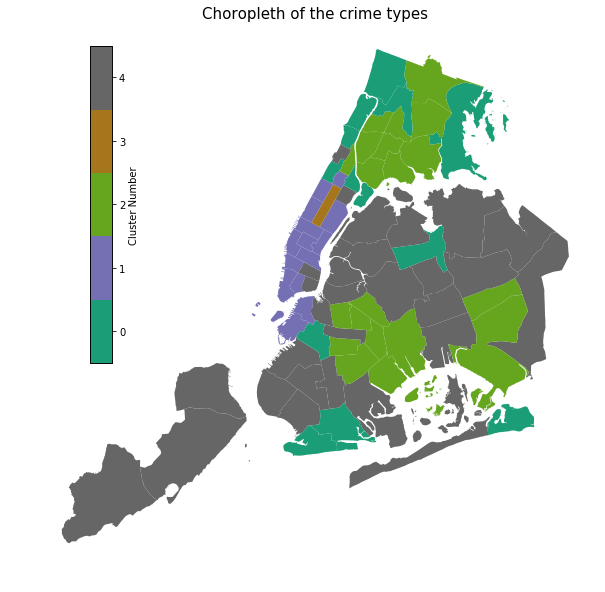

In [76]:
f, ax, cb = cp.choroplethNYC(gdf_crime_socio, 'cluster_crime', kind='discrete', cmap='Dark2')
cb.set_label("Cluster Number", fontsize = 10)
ax.set_title('Choropleth of the crime types', fontsize = 15);

## Figure 13: NYC Choropleth of the 7 crime types

### This one is quite similar to chloropleth of socioeconomic features, showing the relevance of the socioeconomics features with the occurence of crimes

In [77]:
n=2
pca = PCA(n)
Xproj = pca.fit_transform(clustercrime_scaled)
eigenvalues = pca.explained_variance_
print(pca.explained_variance_ratio_.sum())

0.740555273691


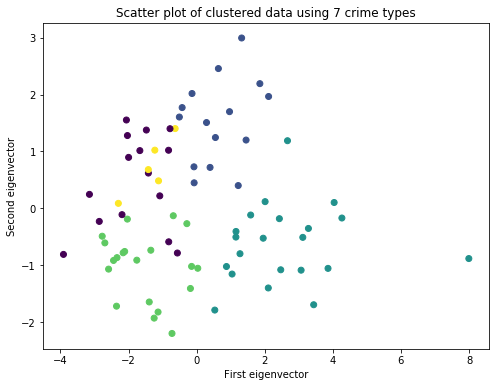

In [78]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Xproj[:, 0], Xproj[:, 1], c= kcrime.labels_)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title("Scatter plot of clustered data using 7 crime types")
plt.show()

## Figure 14: Scatter plot of clustered data using 7 crime type after performing PCA

### Here eigenvector 2 seems more useful, as most of the data can be fitted along it. There are some outliers after 6 along the second eigenvector. The clusters here are more scattered as compared clusters in Figure 11.

## 2.7 At last, create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME

I want this to be a function:

        def fitCrime(...):
            ...
            return importance,quality
    
You can run the function with all the precincts, or with the clusters you created above, but discuss the pros and cons of each scheme. You can use any model. I am ok with multi linear regression, but consider other options: trees, SVM, whatever you have explored in PUI, in other classes, in the EC project. I am not looking for a rigorous assessment. If you use statsmodels for regression you can pull any of the diagnostics in the model.summary() (any of the *appropriate* ones). If you use a machine learning method you can assess via cross validation, seeing how much the score changes between test and training sample. Keep in mind that am definitely more interested in the discussion than in the creation of a "good" model. 

**Discuss explicitly which features are important to predict what** 

In [79]:
def fitCrime(y_predict):
        """
         This function takes the number of crimes for a particular crime type and return the most important feature,
         quality of the model (here Random Forest Regression), along with few other details like time efficiency,
         out of sample scores for 30:70 split and K fold boxplots.
        """

        X = gdf_crime_socio.drop(['BURGLARY', 'FELONY ASSAULT', 'GRAND LARCENY',
                                  'GRAND LARCENY OF MOTOR VEHICLE', 'MURDER & NON NEGL. MANSLAUGHTER',
                                  'RAPE', 'ROBBERY', 'TOTAL SEVEN MAJOR FELONY OFFENSES', "PCT", "geometry",
                                  "cluster_socio", "cluster_crime"],axis = 1)
        Y = y_predict
        X_processed = preprocessing.scale(X)
        t = time.time()
        model = RandomForestRegressor(max_depth=4, random_state=0)
        fittedmodel= model.fit(X_processed, Y)
        quality = cross_val_score(model, X_processed, Y, cv=KFold(n_splits=10, random_state=45443))
        print("Time efficiency = ", time.time() - t, "\n")
        plt.boxplot([quality]);
        plt.title('\nQuality of the model (Random Forest Regression)')
        plt.ylabel('Quality')
        plt.xlabel("Random Forest Regression")
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_processed, Y, test_size=0.3, random_state=99)
        print ("Out of sample score of random forest in-sample for 30-70 split %.2f, out-sample %.2f"%(
        fittedmodel.score(X_train, y_train), fittedmodel.score(X_test, y_test)))
        features_importance = (list(sorted(zip(X.columns, model.feature_importances_), key=lambda a: a[1])))
        print("\nImportance of all the feature:", features_importance)
        importance = features_importance[2]
        return importance,quality

Time efficiency =  0.571903944016 

Out of sample score of random forest in-sample for 30-70 split 0.56, out-sample 0.56

Importance of all the feature: [('unemployment', 0.26316833093506997), ('park access', 0.3643961333066324), ('medianincome', 0.37243553575829758)]

Most importance feature for Burglary: ('medianincome', 0.37243553575829758) 
 
Quality of the model for 10 splits= [ 0.13372692 -0.58439878 -2.51030865 -2.06093525 -1.03002885  0.37756535
  0.43592063 -0.10505915 -3.3520753   0.22400936]


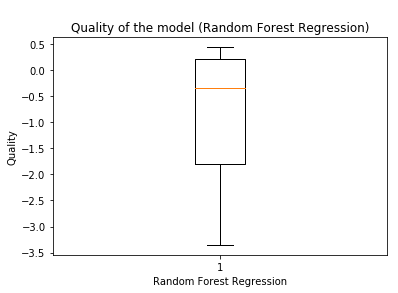

In [80]:
Y = preprocessing.scale(gdf_crime_socio["BURGLARY"])
importance, quality = fitCrime(Y)
print("\nMost importance feature for Burglary:", importance,"\n" ,"\nQuality of the model for 10 splits=", quality)

## Figure 15: Box plot showing the Overall the quality of the model. It is low.

Time efficiency =  0.389184951782 

Out of sample score of random forest in-sample for 30-70 split 0.74, out-sample 0.79

Importance of all the feature: [('park access', 0.083015885368317416), ('unemployment', 0.34752477331701598), ('medianincome', 0.56945934131466658)]

Most importance feature for RAPE: ('medianincome', 0.56945934131466658) 
 
Quality of the model for 10 splits= [-2.70619916 -2.00988166 -0.41992305  0.02732237  0.43199418  0.33739125
  0.68631601  0.42953902  0.28924423  0.22330806]


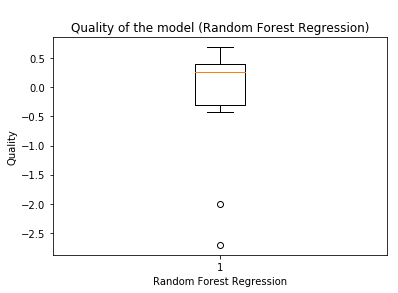

In [81]:
Y = preprocessing.scale(gdf_crime_socio["RAPE"])
importance, quality = fitCrime(Y)
print("\nMost importance feature for RAPE:", importance,"\n" ,"\nQuality of the model for 10 splits=", quality)

## Figure 16: Box plot showing the Overall the quality of the model. It is low.


Time efficiency =  0.378410100937 

Out of sample score of random forest in-sample for 30-70 split 0.80, out-sample 0.87

Importance of all the feature: [('park access', 0.14523414847107025), ('medianincome', 0.28484303746354378), ('unemployment', 0.56992281406538603)]

Most importance feature for MURDER & NON NEGL. MANSLAUGHTER: ('unemployment', 0.56992281406538603) 
 
Quality of the model for 10 splits= [-14.49768956  -2.20891099  -0.51422865  -0.28688515   0.49934296
   0.42138595   0.5315519    0.62370141   0.43935715   0.45788932]


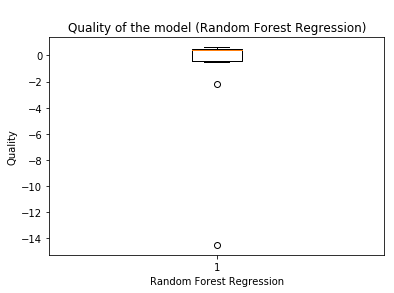

In [82]:
Y = preprocessing.scale(gdf_crime_socio["MURDER & NON NEGL. MANSLAUGHTER"])
importance, quality = fitCrime(Y)
print("\nMost importance feature for MURDER & NON NEGL. MANSLAUGHTER:", importance,"\n" ,
      "\nQuality of the model for 10 splits=", quality)

## Figure 17: Box plot showing the Overall the quality of the model. It is low.

Time efficiency =  0.401916027069 

Out of sample score of random forest in-sample for 30-70 split 0.52, out-sample 0.82

Importance of all the feature: [('unemployment', 0.14020207269489021), ('park access', 0.38200749807210932), ('medianincome', 0.47779042923300052)]

Most importance feature for the total SEVEN MAJOR FELONY OFFENSES: ('medianincome', 0.47779042923300052) 
 
Quality of the model for 10 splits= [ 0.45470236 -0.2607639  -0.53048786 -0.27419699 -0.35196747  0.21713301
 -2.40503094 -0.10976637 -0.78341392  0.57678697]


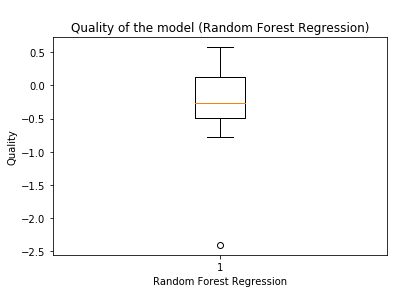

In [83]:
Y = preprocessing.scale(gdf_crime_socio["TOTAL SEVEN MAJOR FELONY OFFENSES"])
importance, quality = fitCrime(Y)
print("\nMost importance feature for the total SEVEN MAJOR FELONY OFFENSES:", importance,"\n" ,
      "\nQuality of the model for 10 splits=", quality)

## Figure 18: Box plot showing the Overall the quality of the model. It is low.

## Overall: Median income is the most feature for predicting the occurence of crime. The model has overall low quality, but for 30-70 split of the data, the model quality is better. One of the reasons for low model quality, is that these features are insufficient in predicting the crime occurence and doesn't give the overall picture.

# Extra Credit 

I decided to add this as the conversation kept getting pushed toward details of spatial joins during the final reviews. If this all was easy, recreate the percentage of green area in a precinct, the unemployment rate by precinct, and the median income by precinct.

you will need:
a shapefile for the NYC parks which you can access from the https://data.cityofnewyork.us/. With the overlay function get the area of the green spaces contained in a precinct. 
I only selectted the following park subcategories. 

selectedParks = ['Community Park', 'Recreation Field/Courts', 'Triangle/Plaza',
       'Garden', 'Neighborhood Park', 'Nature Area', 'Waterfront Facility',
       'Historic House Park', 'Playground', 
       'Flagship Park', 
       'Jointly Operated Playground', 'Managed Sites']


A census tract shapefile is also accessible through the NYC open data portal or http://www1.nyc.gov/site/planning/data-maps/open-data.page
    
Overlay the census tract and precinct geometries (geopandas.overlay) to get the fraction of each tract in a precinct. This will allow you to create a weighted average of the unemployment percentage and median income.

You will need tree features from the American Community Survey which you can find on American Fact Finder.   
If, as they should, these are accessed through the API your API link should begin with https://api.census.gov/ (e.g. [5 year ACS](https://www.census.gov/data/developers/data-sets/acs-5year.html))

- the 2015  5 year ACS survey unemployment data by census tract (the total number of individuals is available through the API at the census tract geometry aggregation level. 

- the 2015  5 year ACS survey total count of people by census tract (to generate the unemployment percentage).

- the 2015  5 year ACS survey median income by census tract.

Some precinct geometries will fail, and likely will report that the operation is not doable with MultiPolygons. These operations are actually doable with MultyPolygons, but some of the precincts have non valid geometries. For those you can use the convex hull (pctshp.geometry.map(lambda x: x.convex_hull)) to get the intersection, with some loss (is the loss in accuracy or precision?)